In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import sympy as sp
import cplot
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm.notebook import tqdm
from ipywidgets import interact
from oetils import init_plotting

In [2]:
_ = init_plotting(latex=True, sans=True)

---

# Exercise 3.2

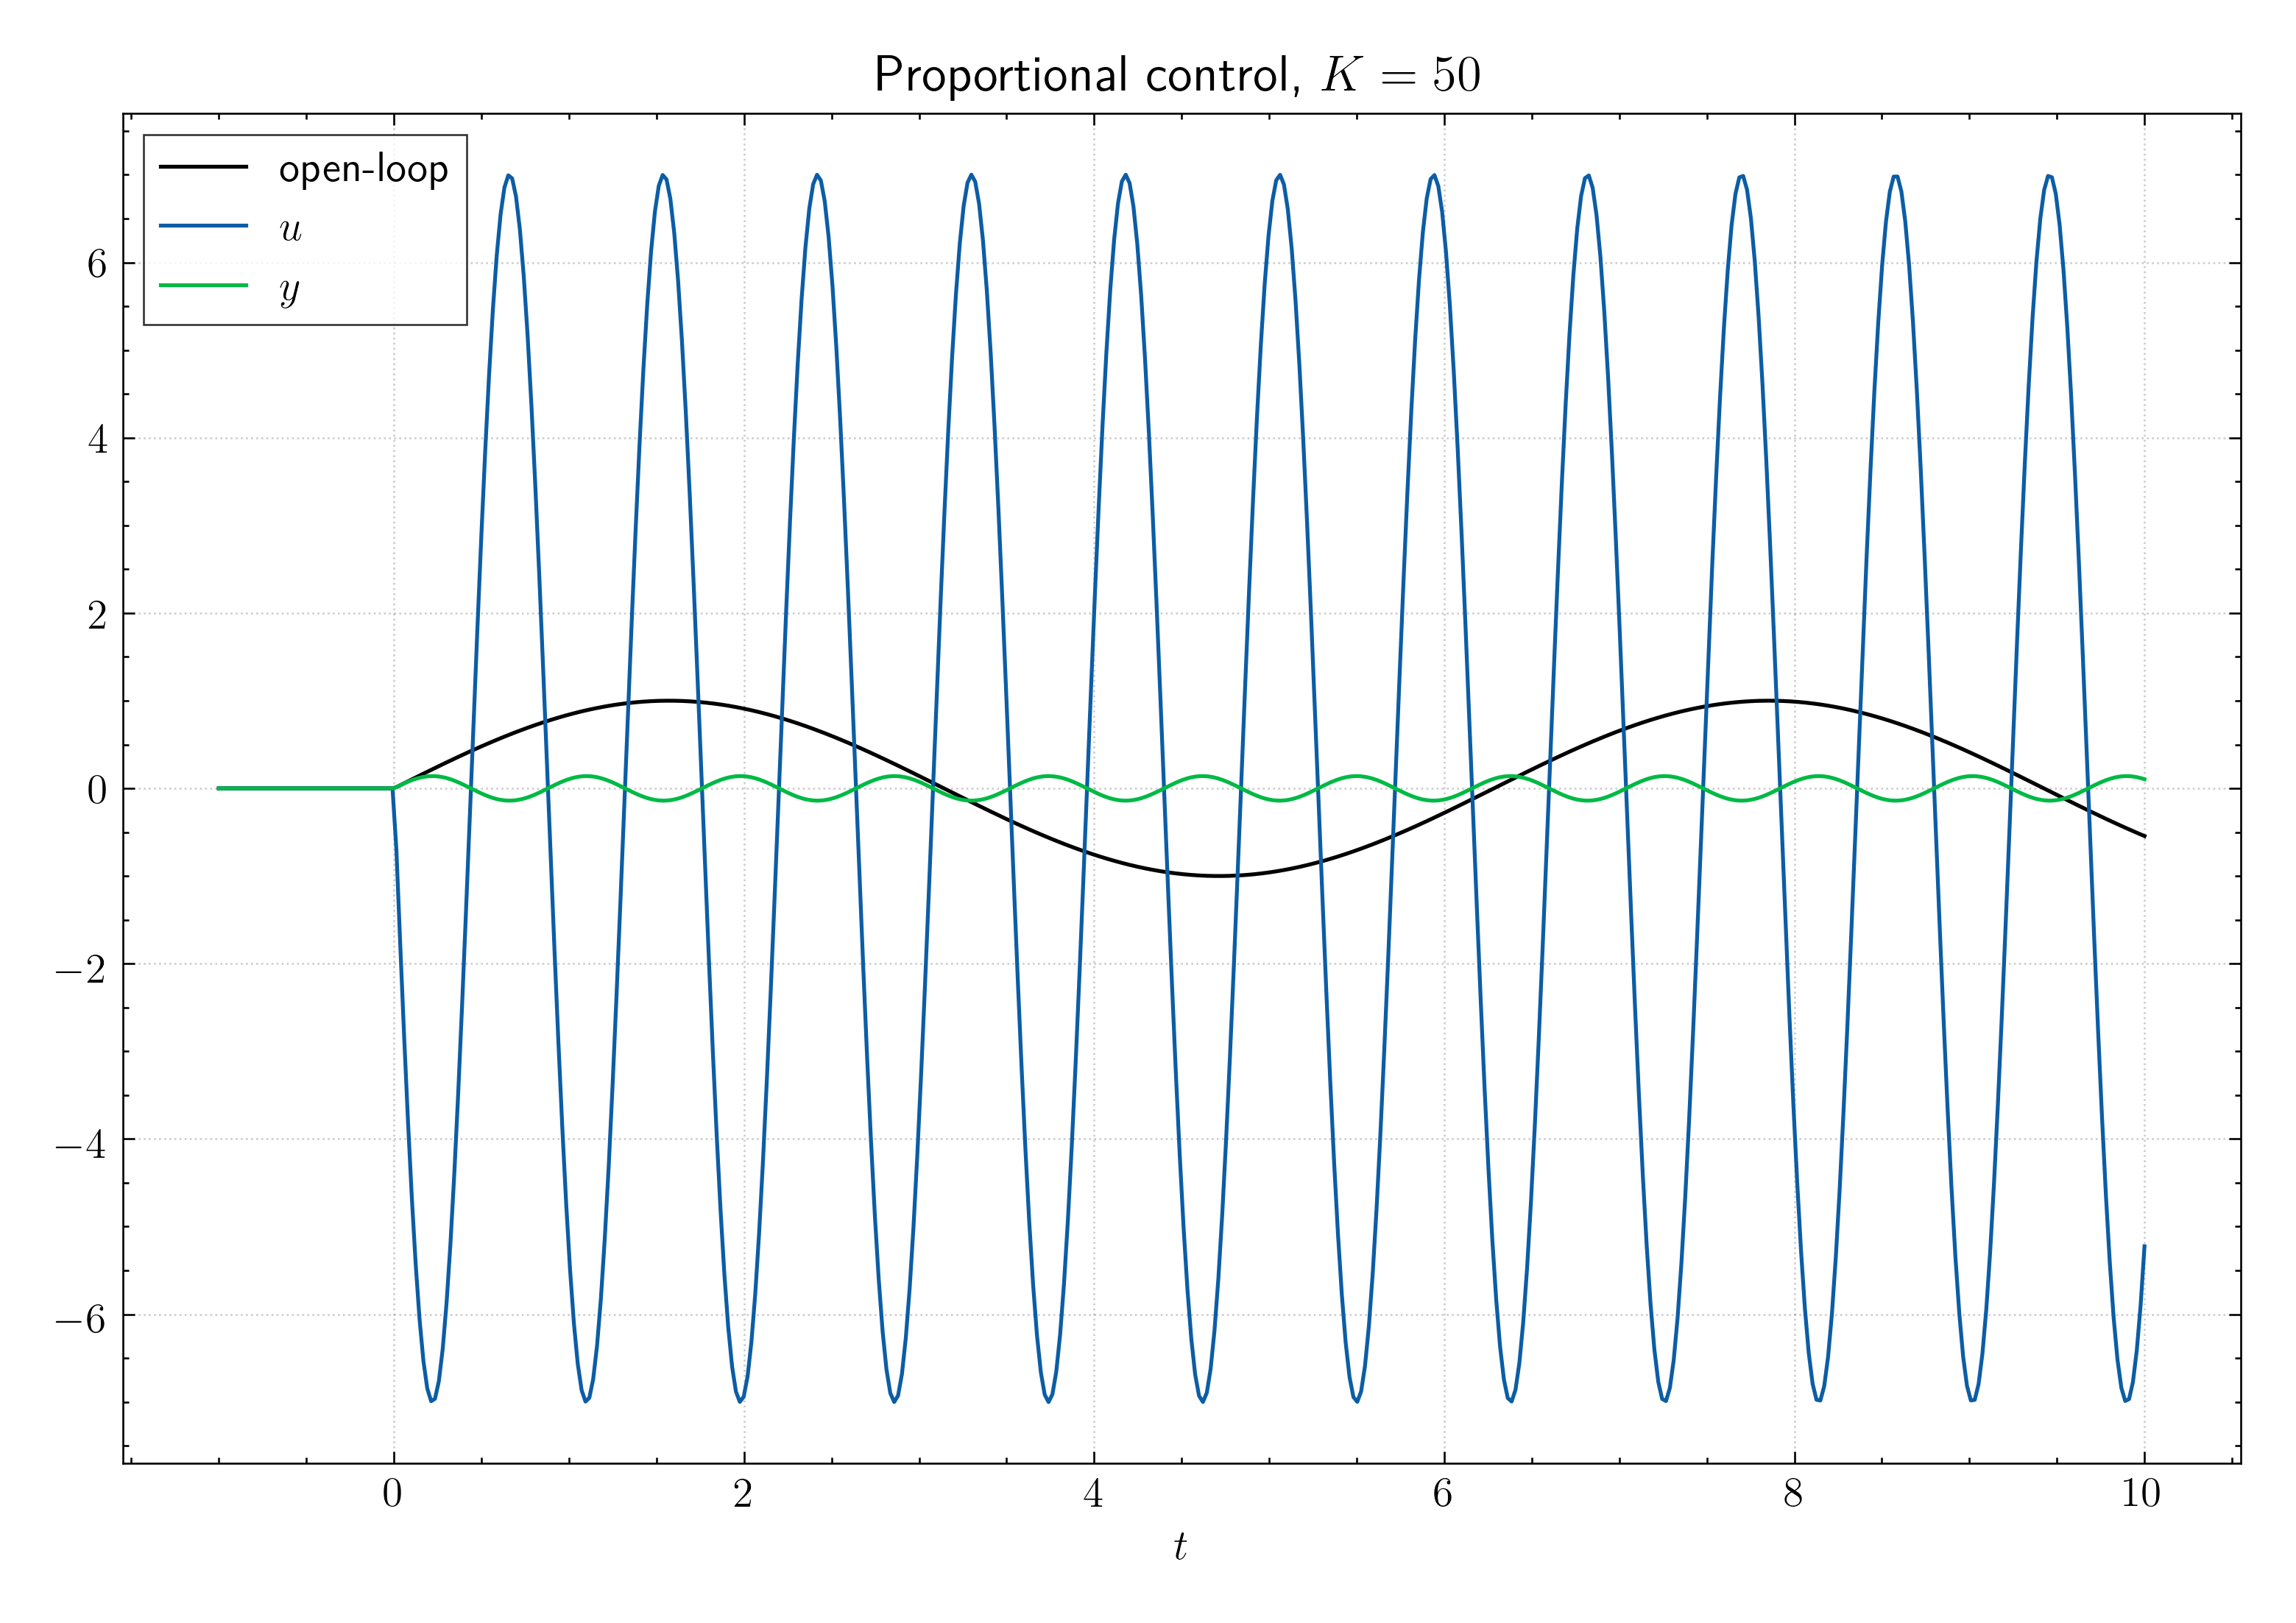

In [3]:
# Proportional control
t = np.linspace(-1, 10, 500)

def plot(K):
    fig, ax = plt.subplots()
    w = np.sqrt(K + 1)
    y = np.where(t < 0, 0, np.sin(w*t) / w)
    u = np.where(t < 0, 0, -K * np.sin(w*t) / w)
    ax.plot(t, np.where(t < 0, 0, np.sin(t)), 'k', label="open-loop")
    ax.plot(t, u, label="$u$")
    ax.plot(t, y, label="$y$")
    ax.set_title(f"Proportional control, $K = {int(K)}$")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, K=widgets.FloatSlider(value=50.0, min=0, max=100, step=1.0))
plot(K=50)

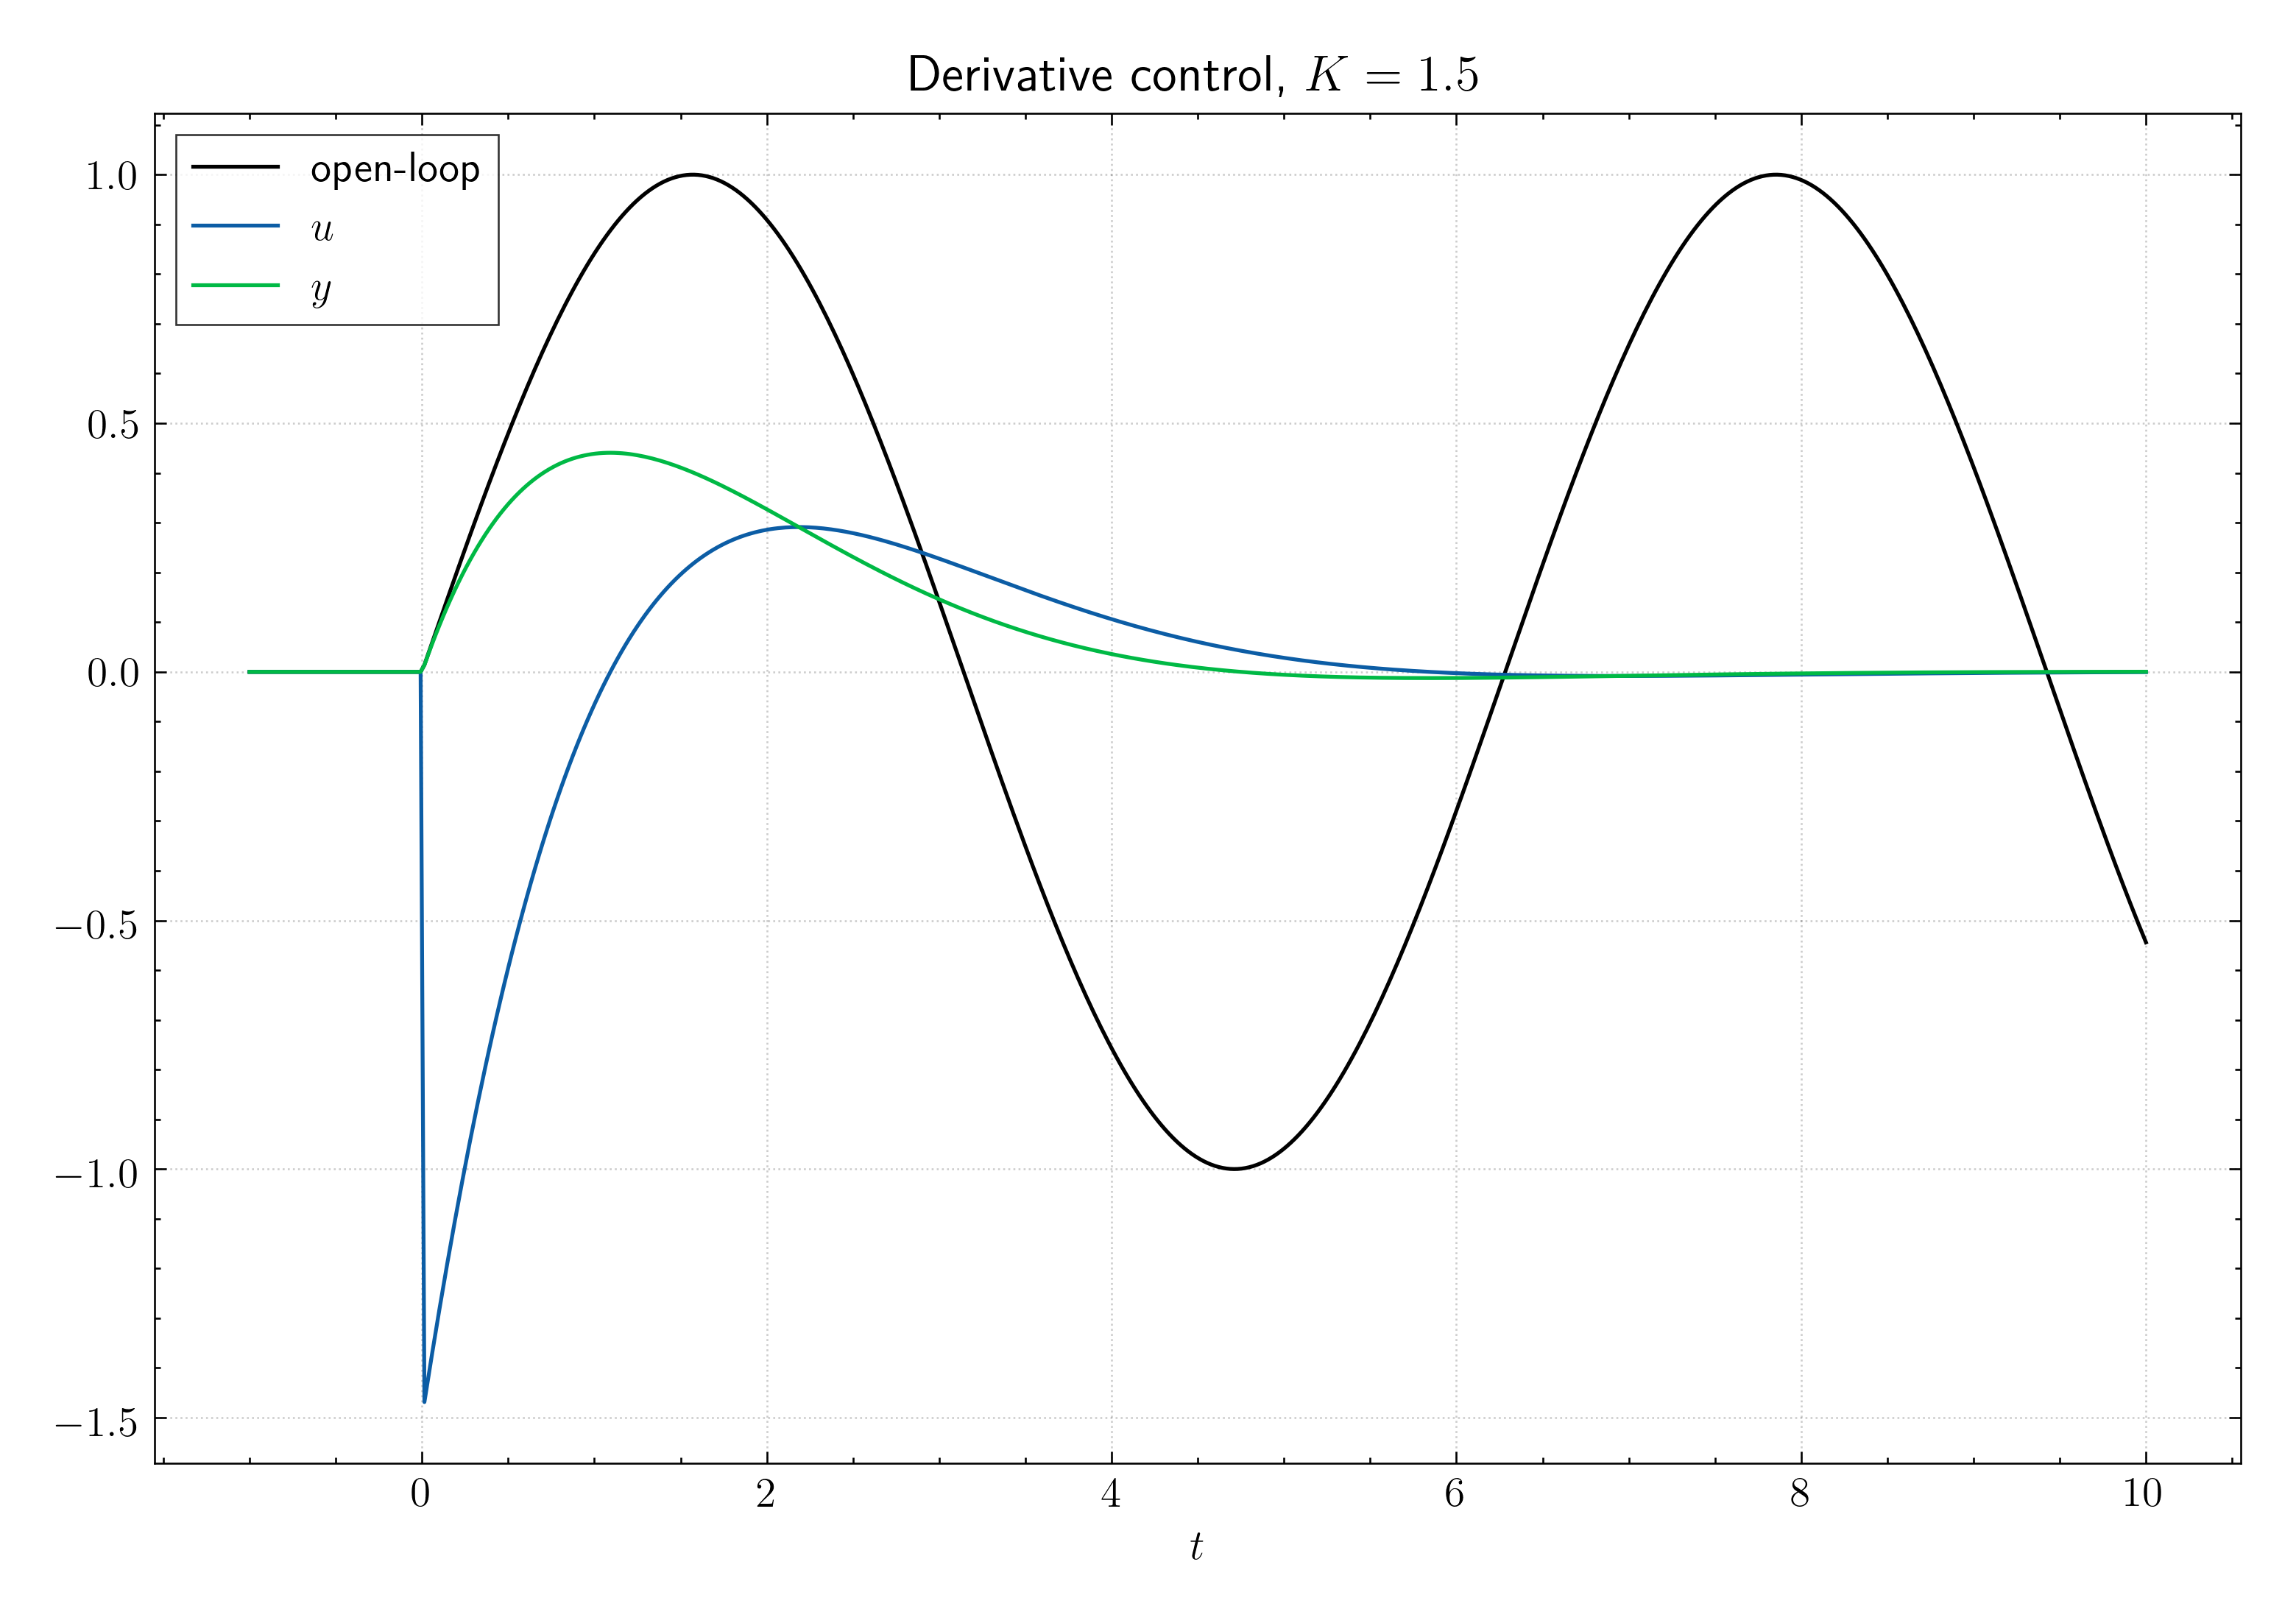

In [4]:
# Derivative control
t = np.linspace(-1, 10, 500)

def plot(K):
    fig, ax = plt.subplots()
    a = K/2
    w = np.sqrt(1 - a**2)
    y = np.where(t < 0, 0, np.exp(-a*t) * np.sin(w*t) / w)
    u = np.where(t < 0, 0, K**2 / (2*w) * np.exp(-a*t) * np.sin(w*t) - K * np.exp(-a*t) * np.cos(w*t))
    ax.plot(t, np.where(t < 0, 0, np.sin(t)), 'k', label="open-loop")
    ax.plot(t, u, label="$u$")
    ax.plot(t, y, label="$y$")
    ax.set_title(f"Derivative control, $K = {K:.1f}$")
    ax.set_xlabel("$t$")
    plt.legend()
    plt.show()

# interact(plot, K=widgets.FloatSlider(value=1.5, min=0, max=2, step=0.1))
plot(K=1.5)

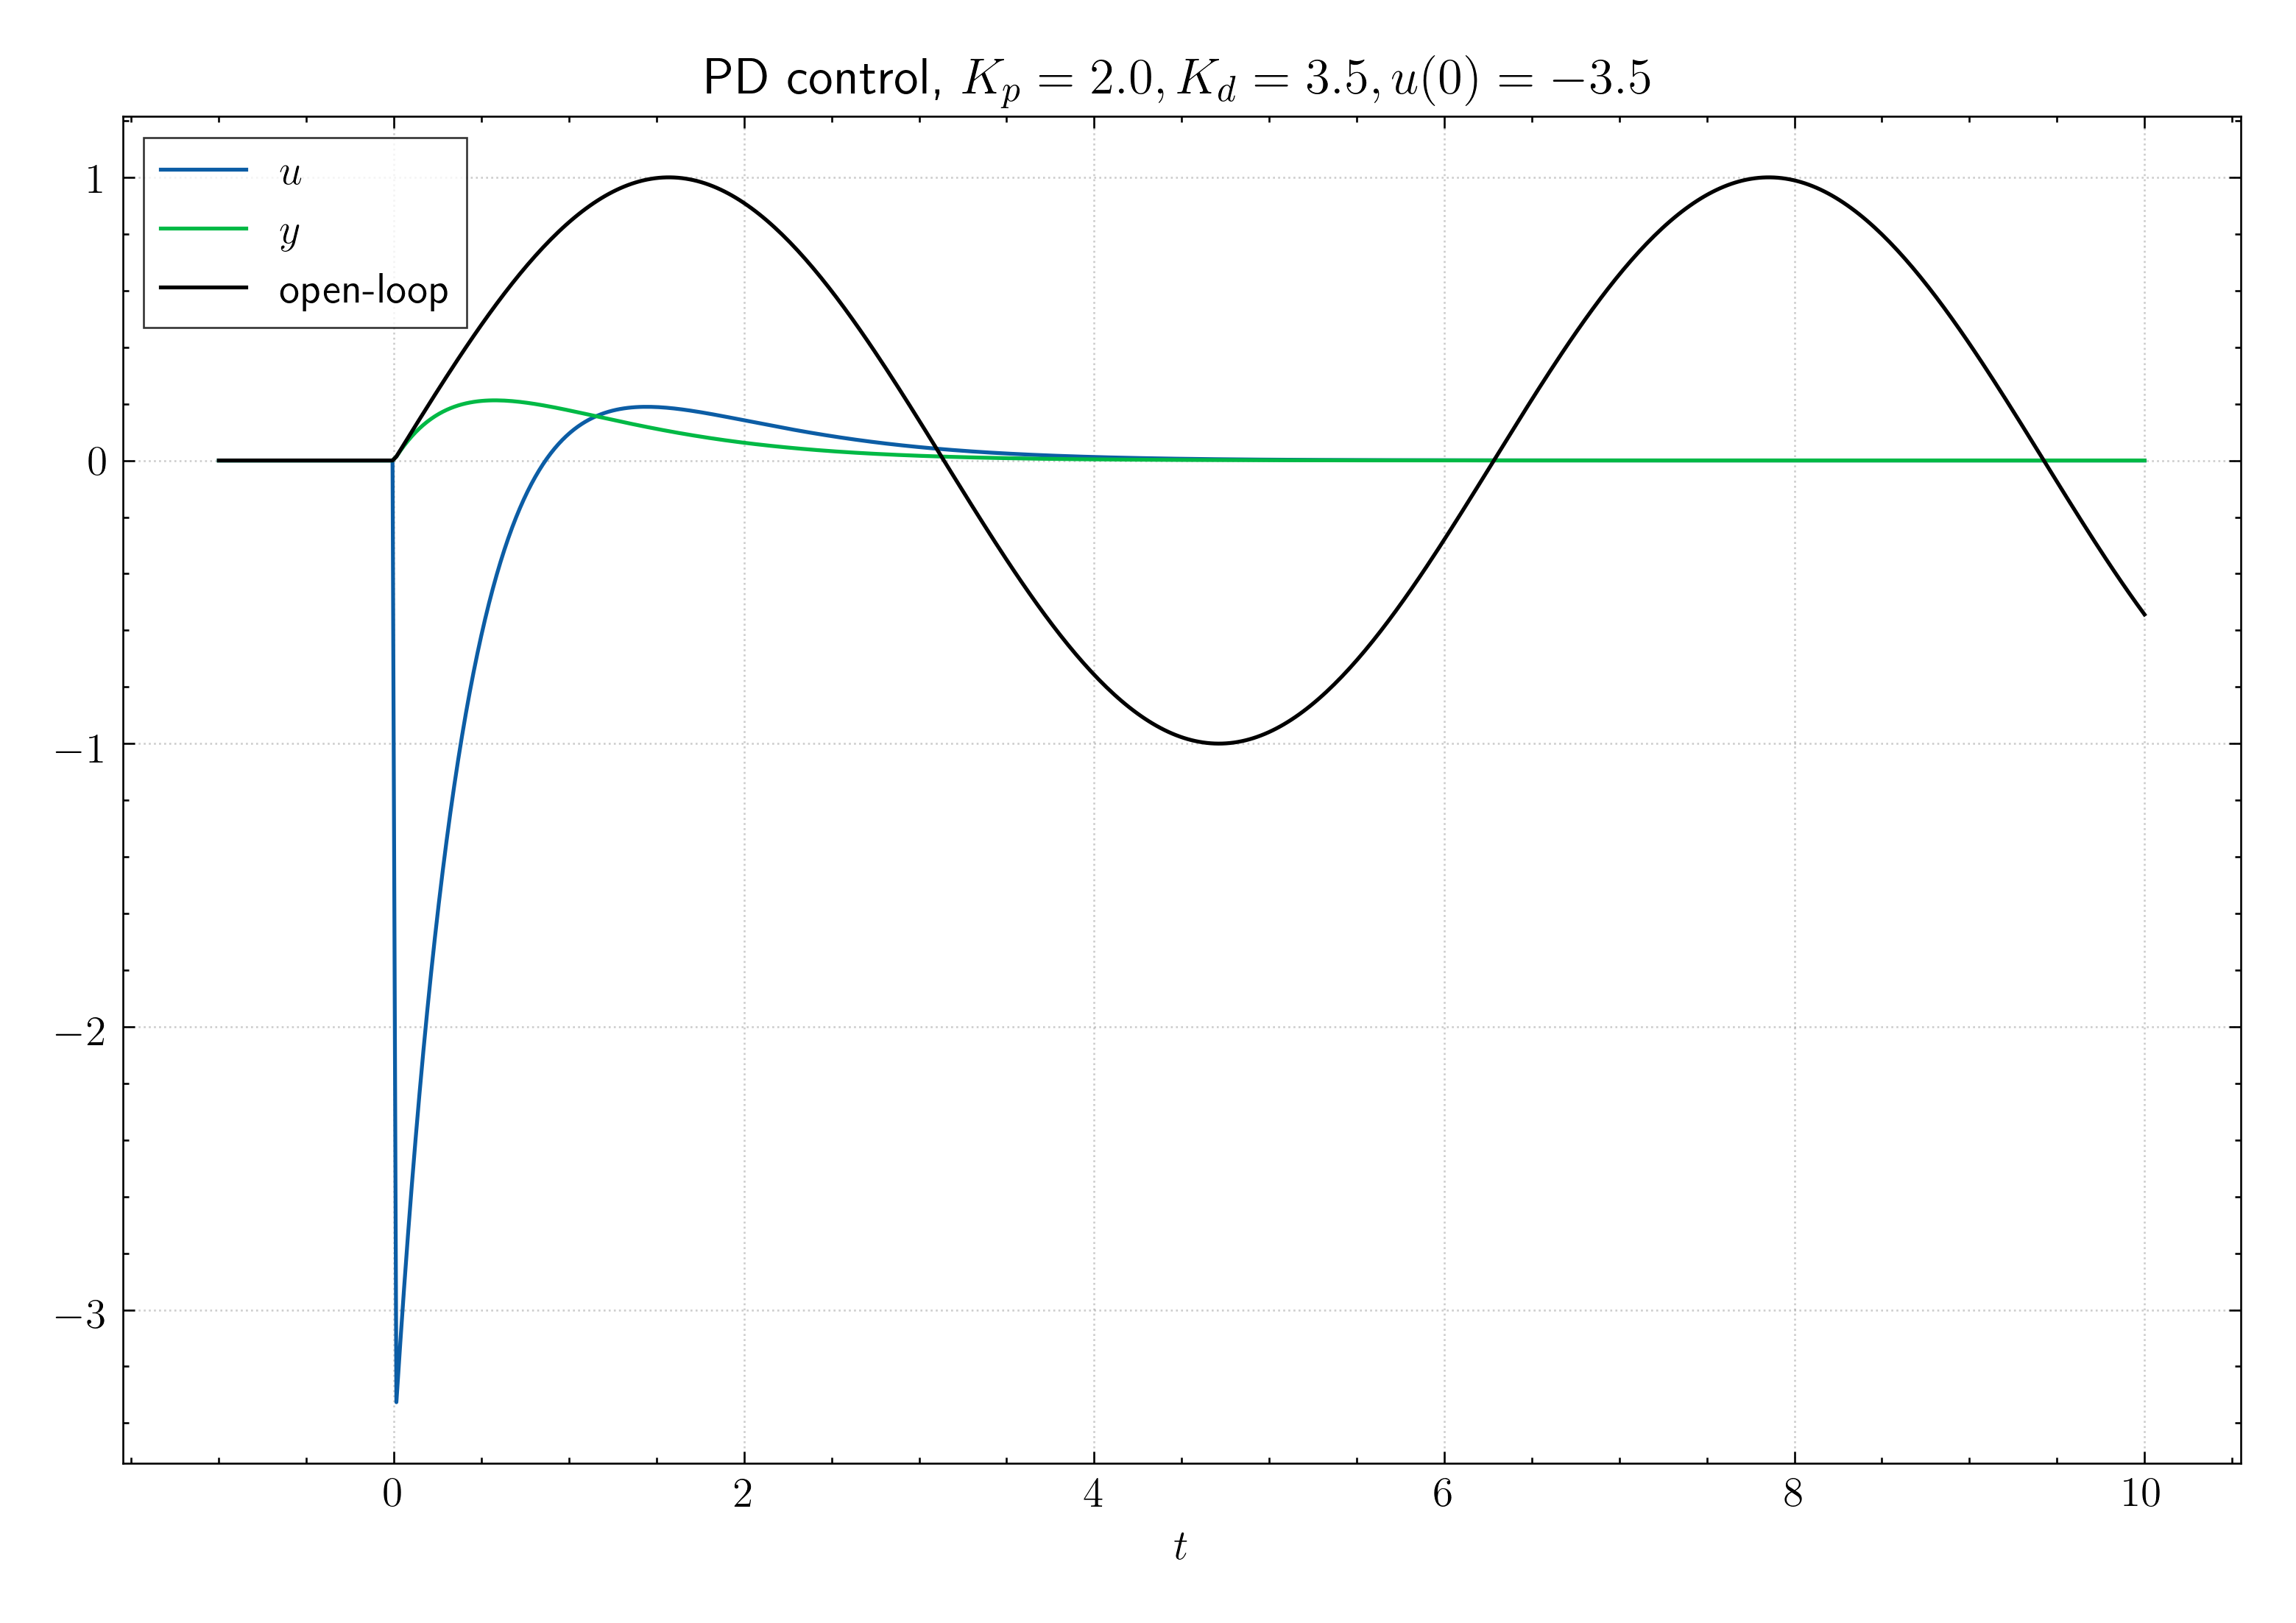

In [5]:
# PD control with critical damping
t = np.linspace(-1, 10, 500)

def plot(K_p):
    fig, ax = plt.subplots()
    y = np.where(t < 0, 0, t * np.exp(-np.sqrt(K_p + 1)*t))
    u = np.where(t < 0, 0, ((K_p + 2)*t - 2*np.sqrt(K_p + 1)) * np.exp(-np.sqrt(K_p + 1)*t))
    # ax.axhline(-2*np.sqrt(K_p + 1), c='C1', ls='--', label='$u(0)$')
    ax.plot(t, u, label="$u$")
    ax.plot(t, y, label="$y$")
    ax.set_title(f"PD control, $K_p = {K_p:.1f}, K_d = {2*np.sqrt(K_p + 1):.1f}, u(0) = {-2*np.sqrt(K_p + 1):.1f}$")
    ax.plot(t, np.where(t < 0, 0, np.sin(t)), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, K_p=widgets.FloatSlider(value=2.0, min=0, max=100, step=0.1))
plot(K_p=2)

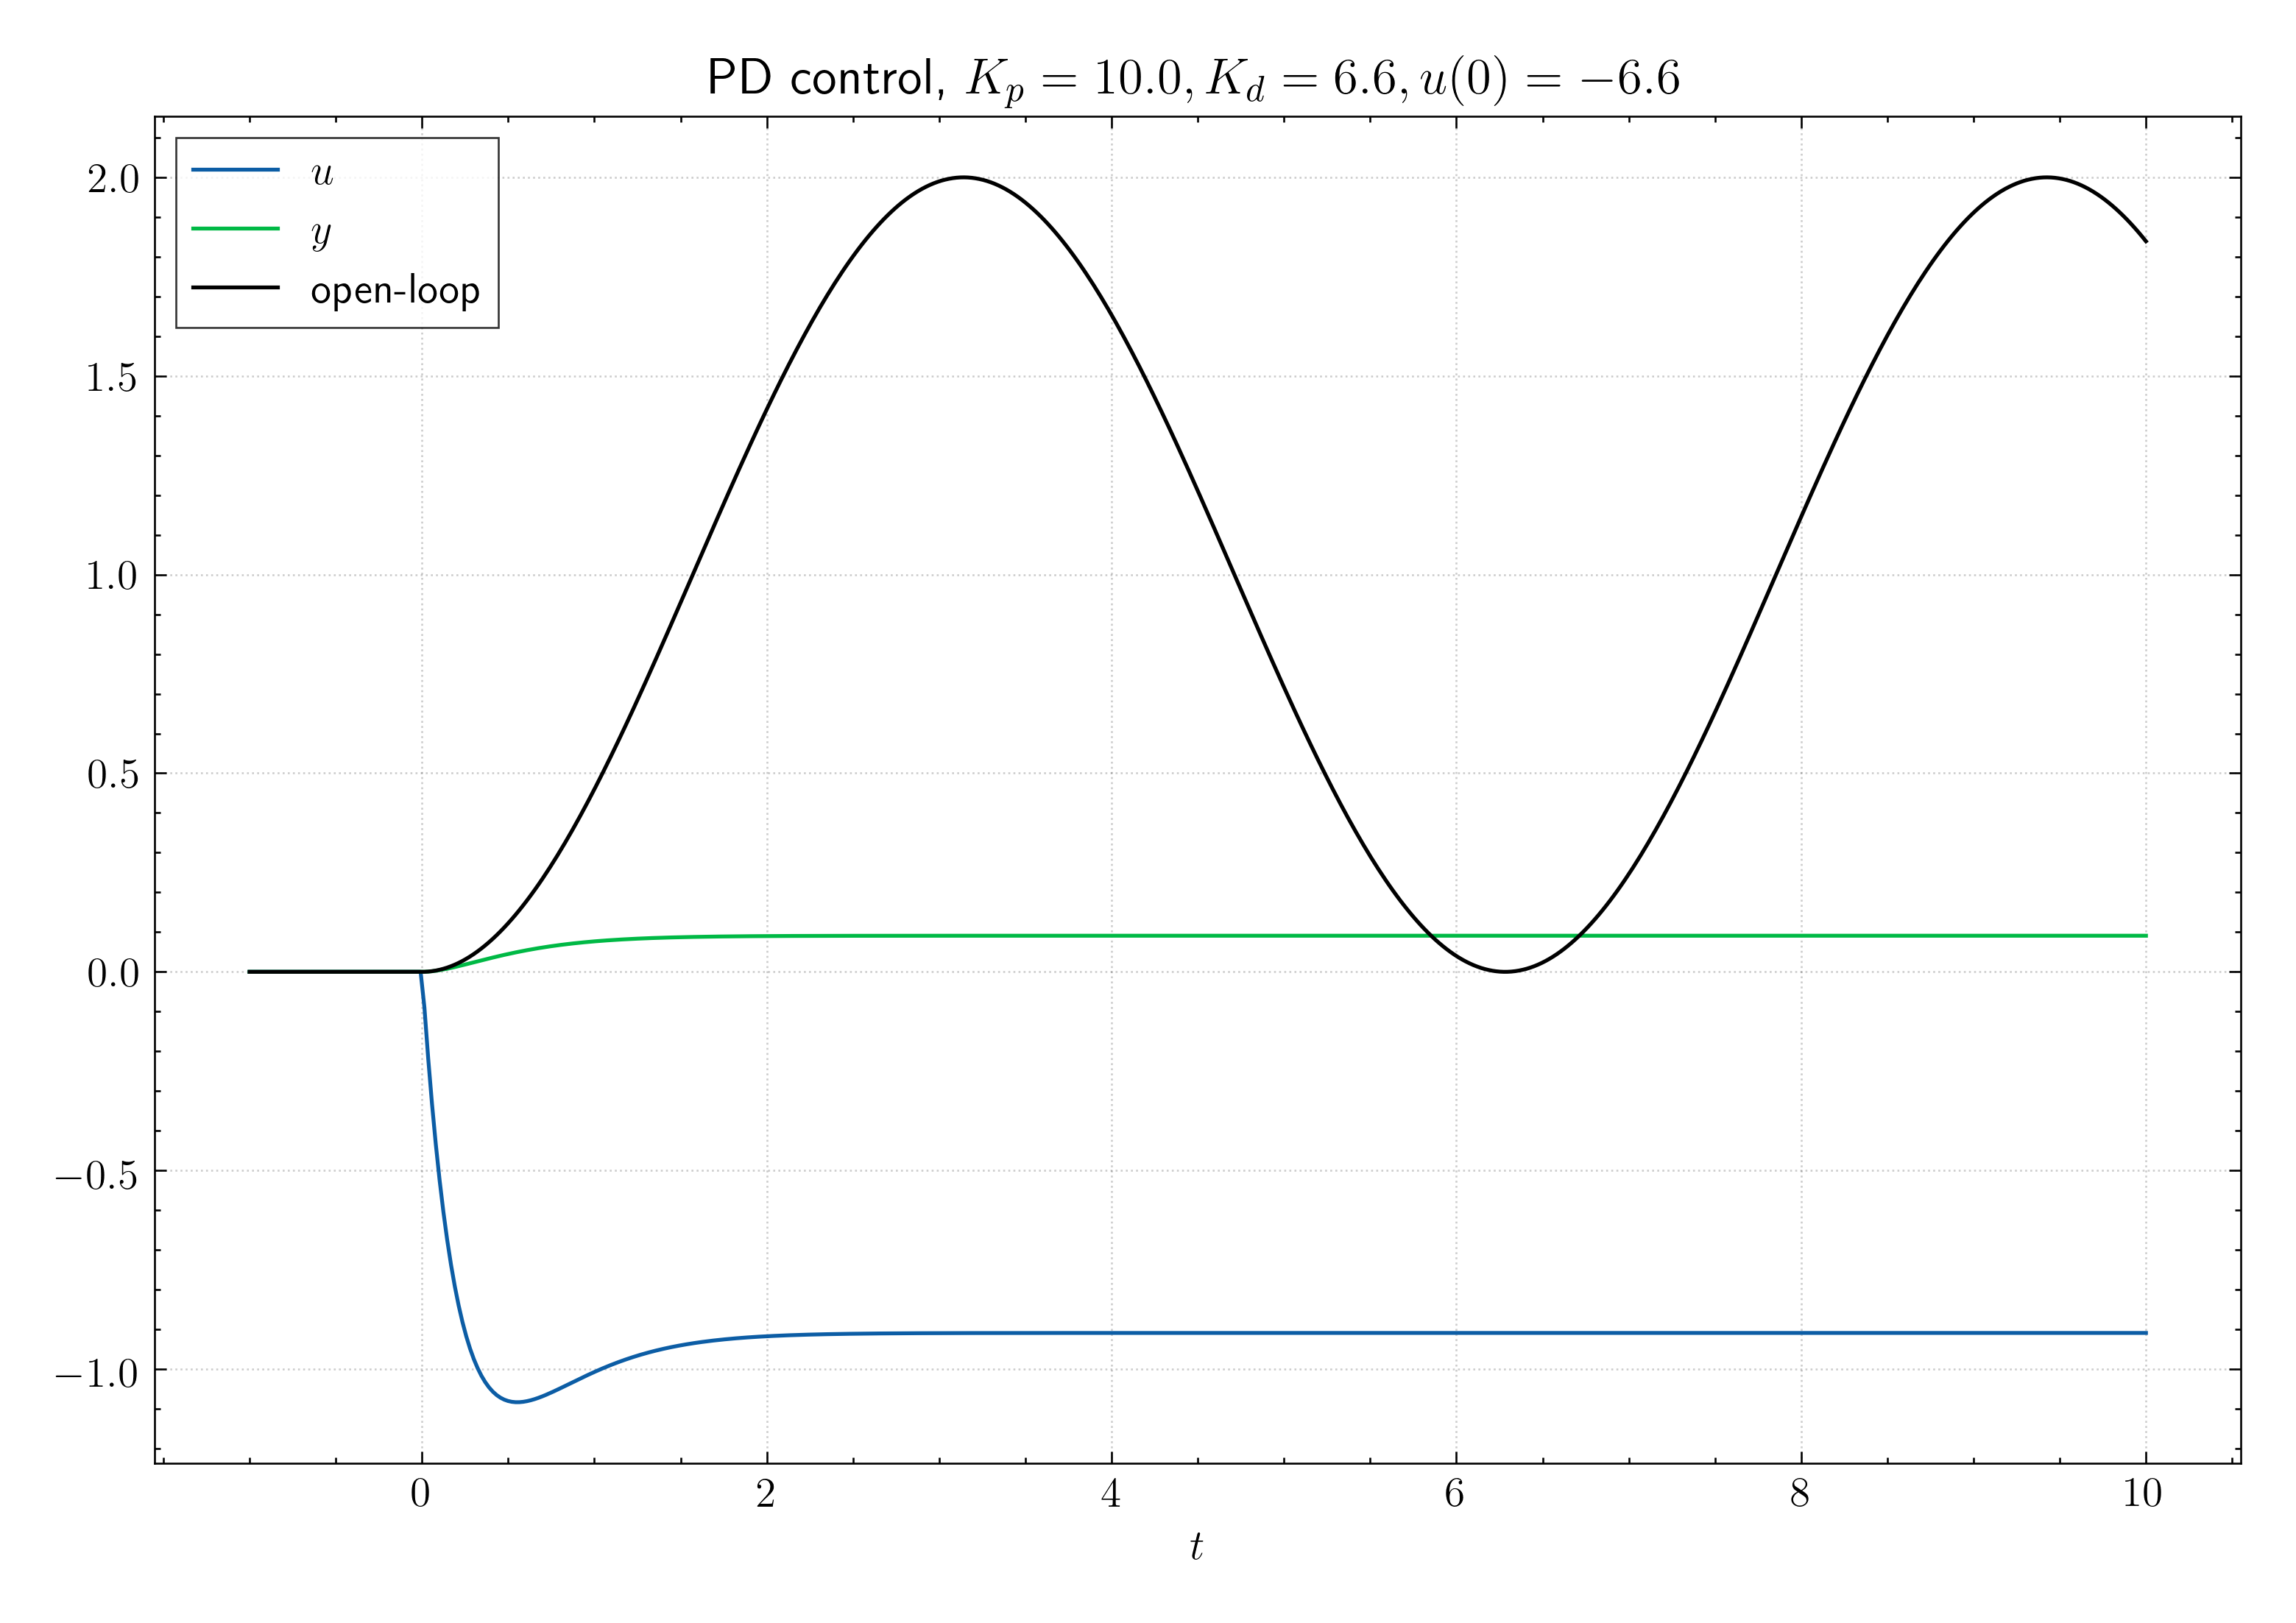

In [6]:
# PD control with critical damping, step response
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_d = sp.S('t, s, K_p, K_d')
G = 1/(1 + s**2)
d = 1/s
K = K_p + K_d*s
y = G / (1 + K*G) * d
u = -K * y
y = y.subs(K_p, (K_d / 2)**2 - 1)
u = u.subs(K_p, (K_d / 2)**2 - 1)
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, K_d), y)
u = sp.lambdify((t, K_d), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * d, s, t))

def plot(K_p):
    fig, ax = plt.subplots()
    K_d = 2*np.sqrt(K_p + 1)
    # u = np.where(t < 0, 0, ((K_p + 2)*t - 2*np.sqrt(K_p + 1)) * np.exp(-np.sqrt(K_p + 1)*t))
    # ax.axhline(-2*np.sqrt(K_p + 1), c='C1', ls='--', label='$u(0)$')
    # ax.plot(t, u, label="$u$")
    ax.plot(t_, u(t_, K_d*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, K_d*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PD control, $K_p = {K_p:.1f}, K_d = {2*np.sqrt(K_p + 1):.1f}, u(0) = {-2*np.sqrt(K_p + 1):.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, K_p=widgets.FloatSlider(value=10.0, min=0, max=100, step=0.1))
plot(K_p=10)

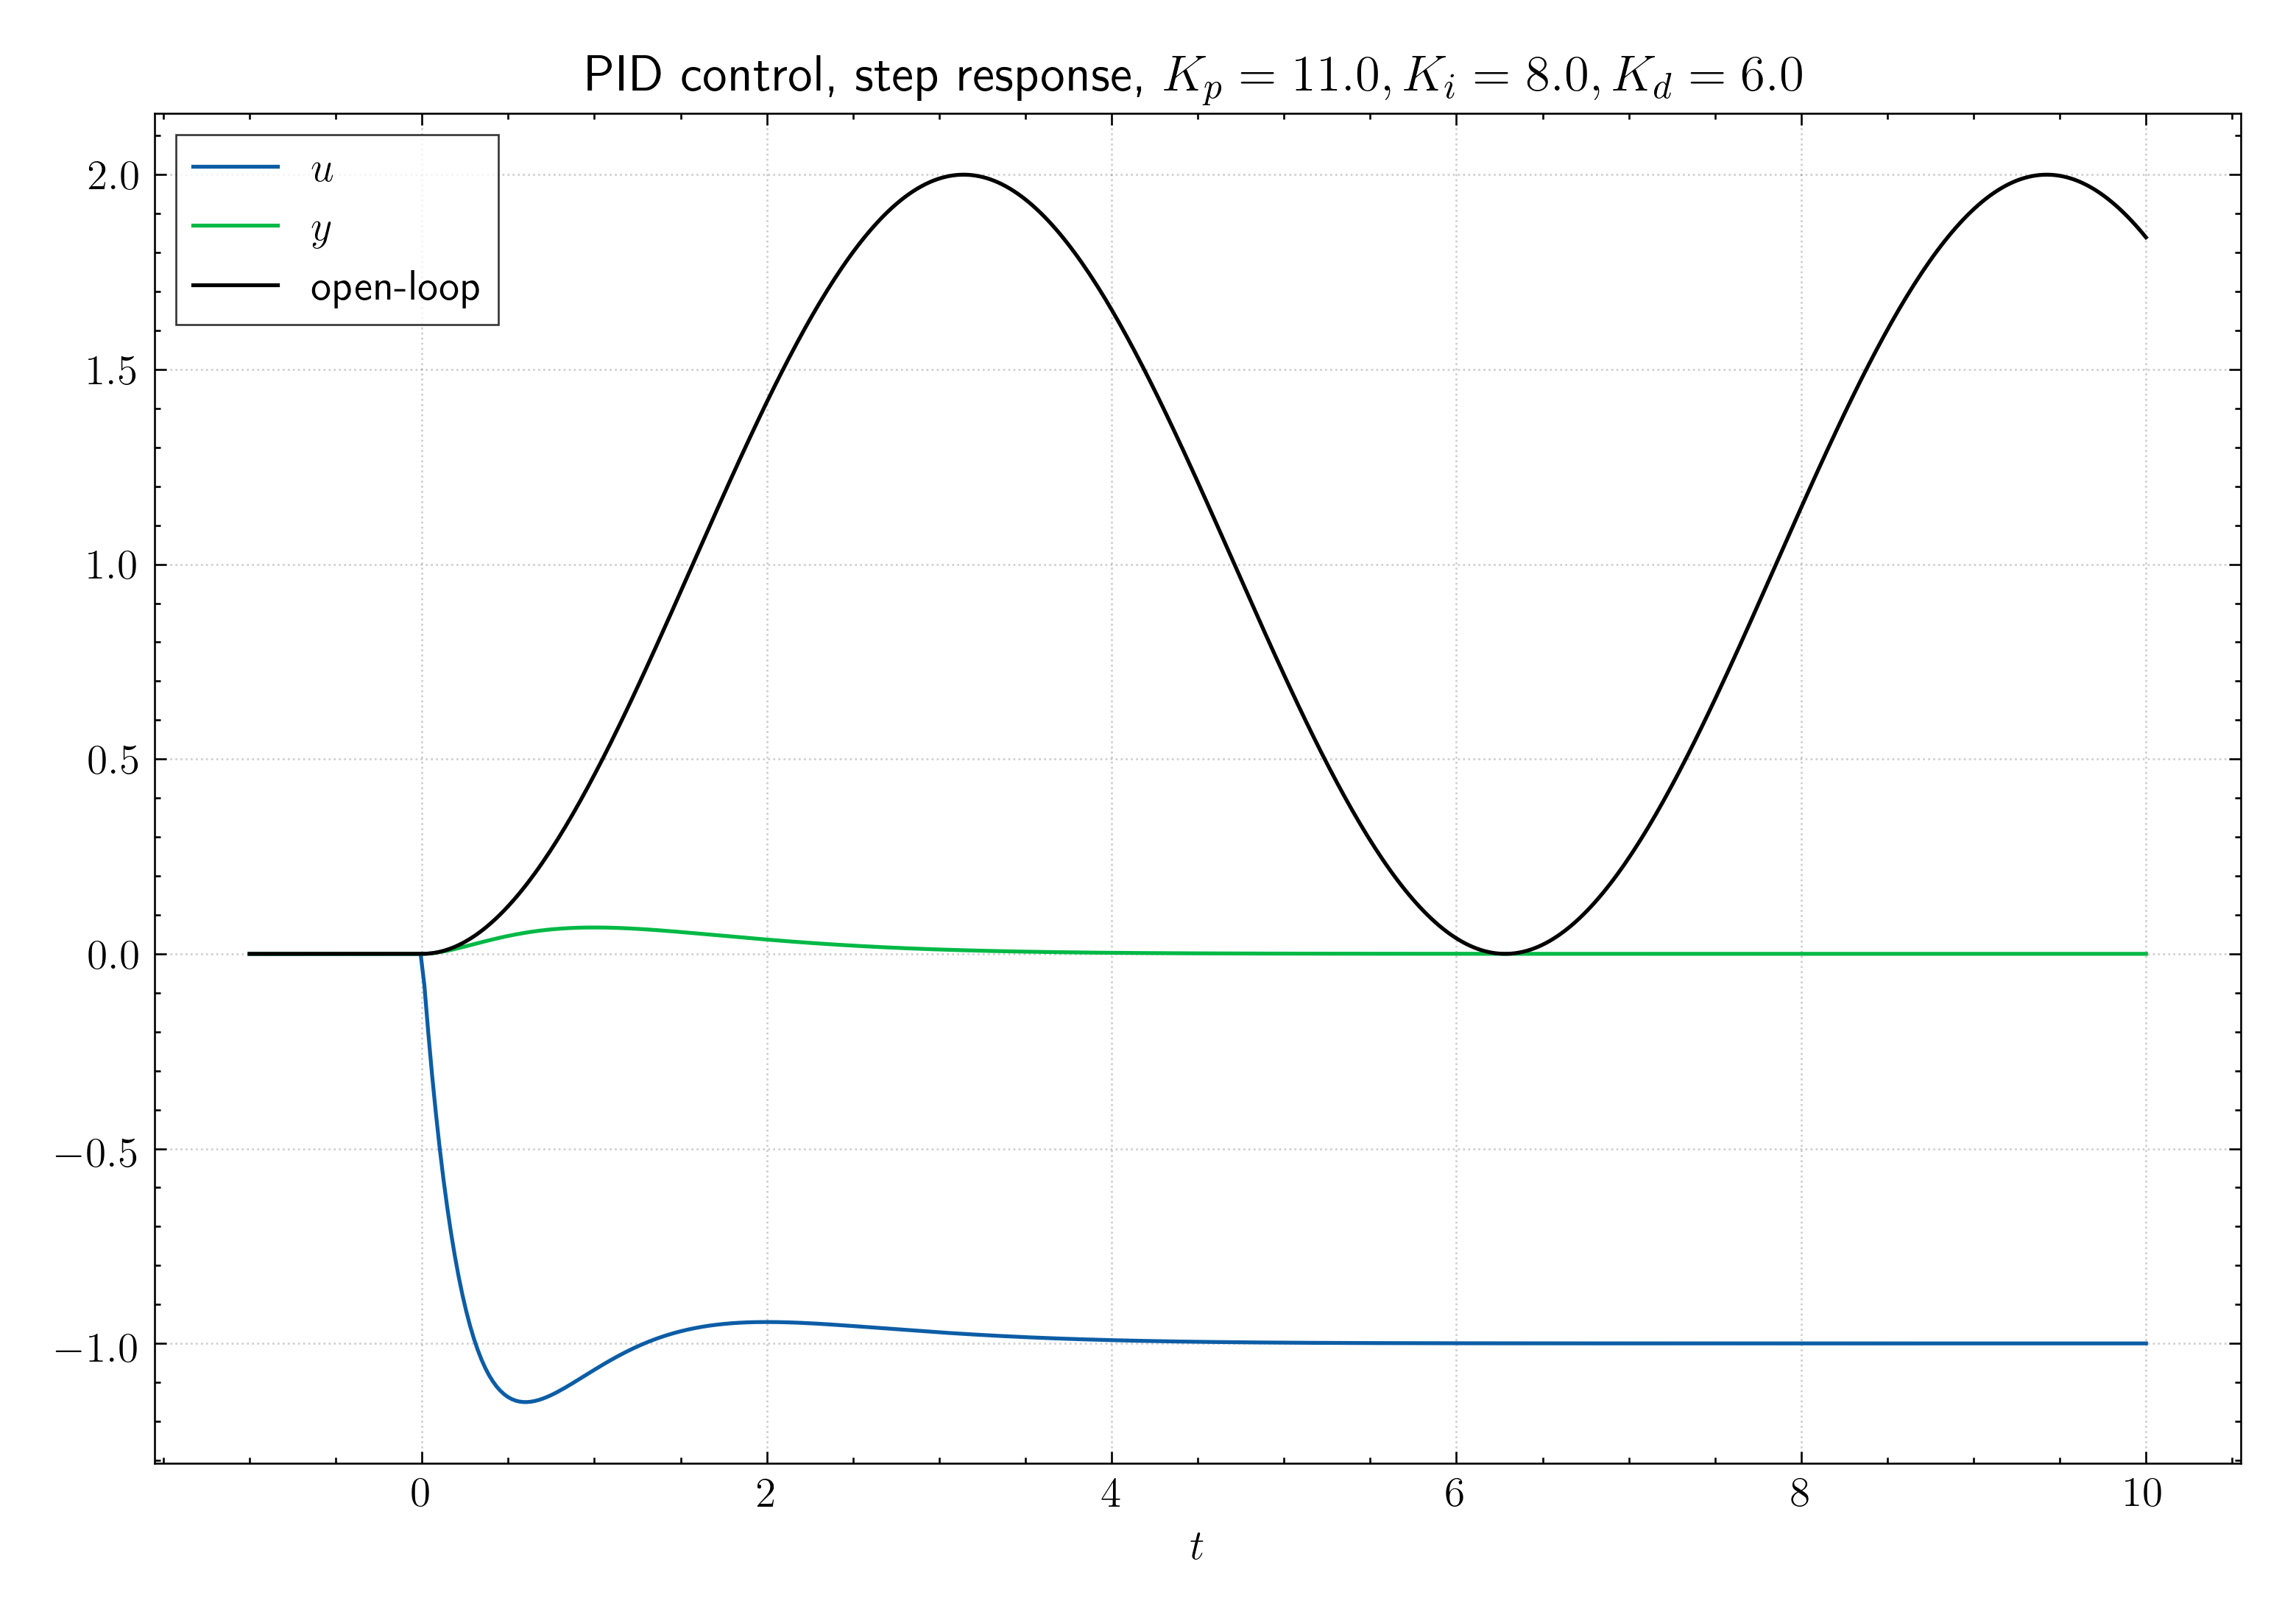

In [7]:
# PID control step response
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
d = 1/s
K = K_p + K_d*s + K_i/s
y = G / (1 + K*G) * d
u = -K * y
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * d, s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, step response, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

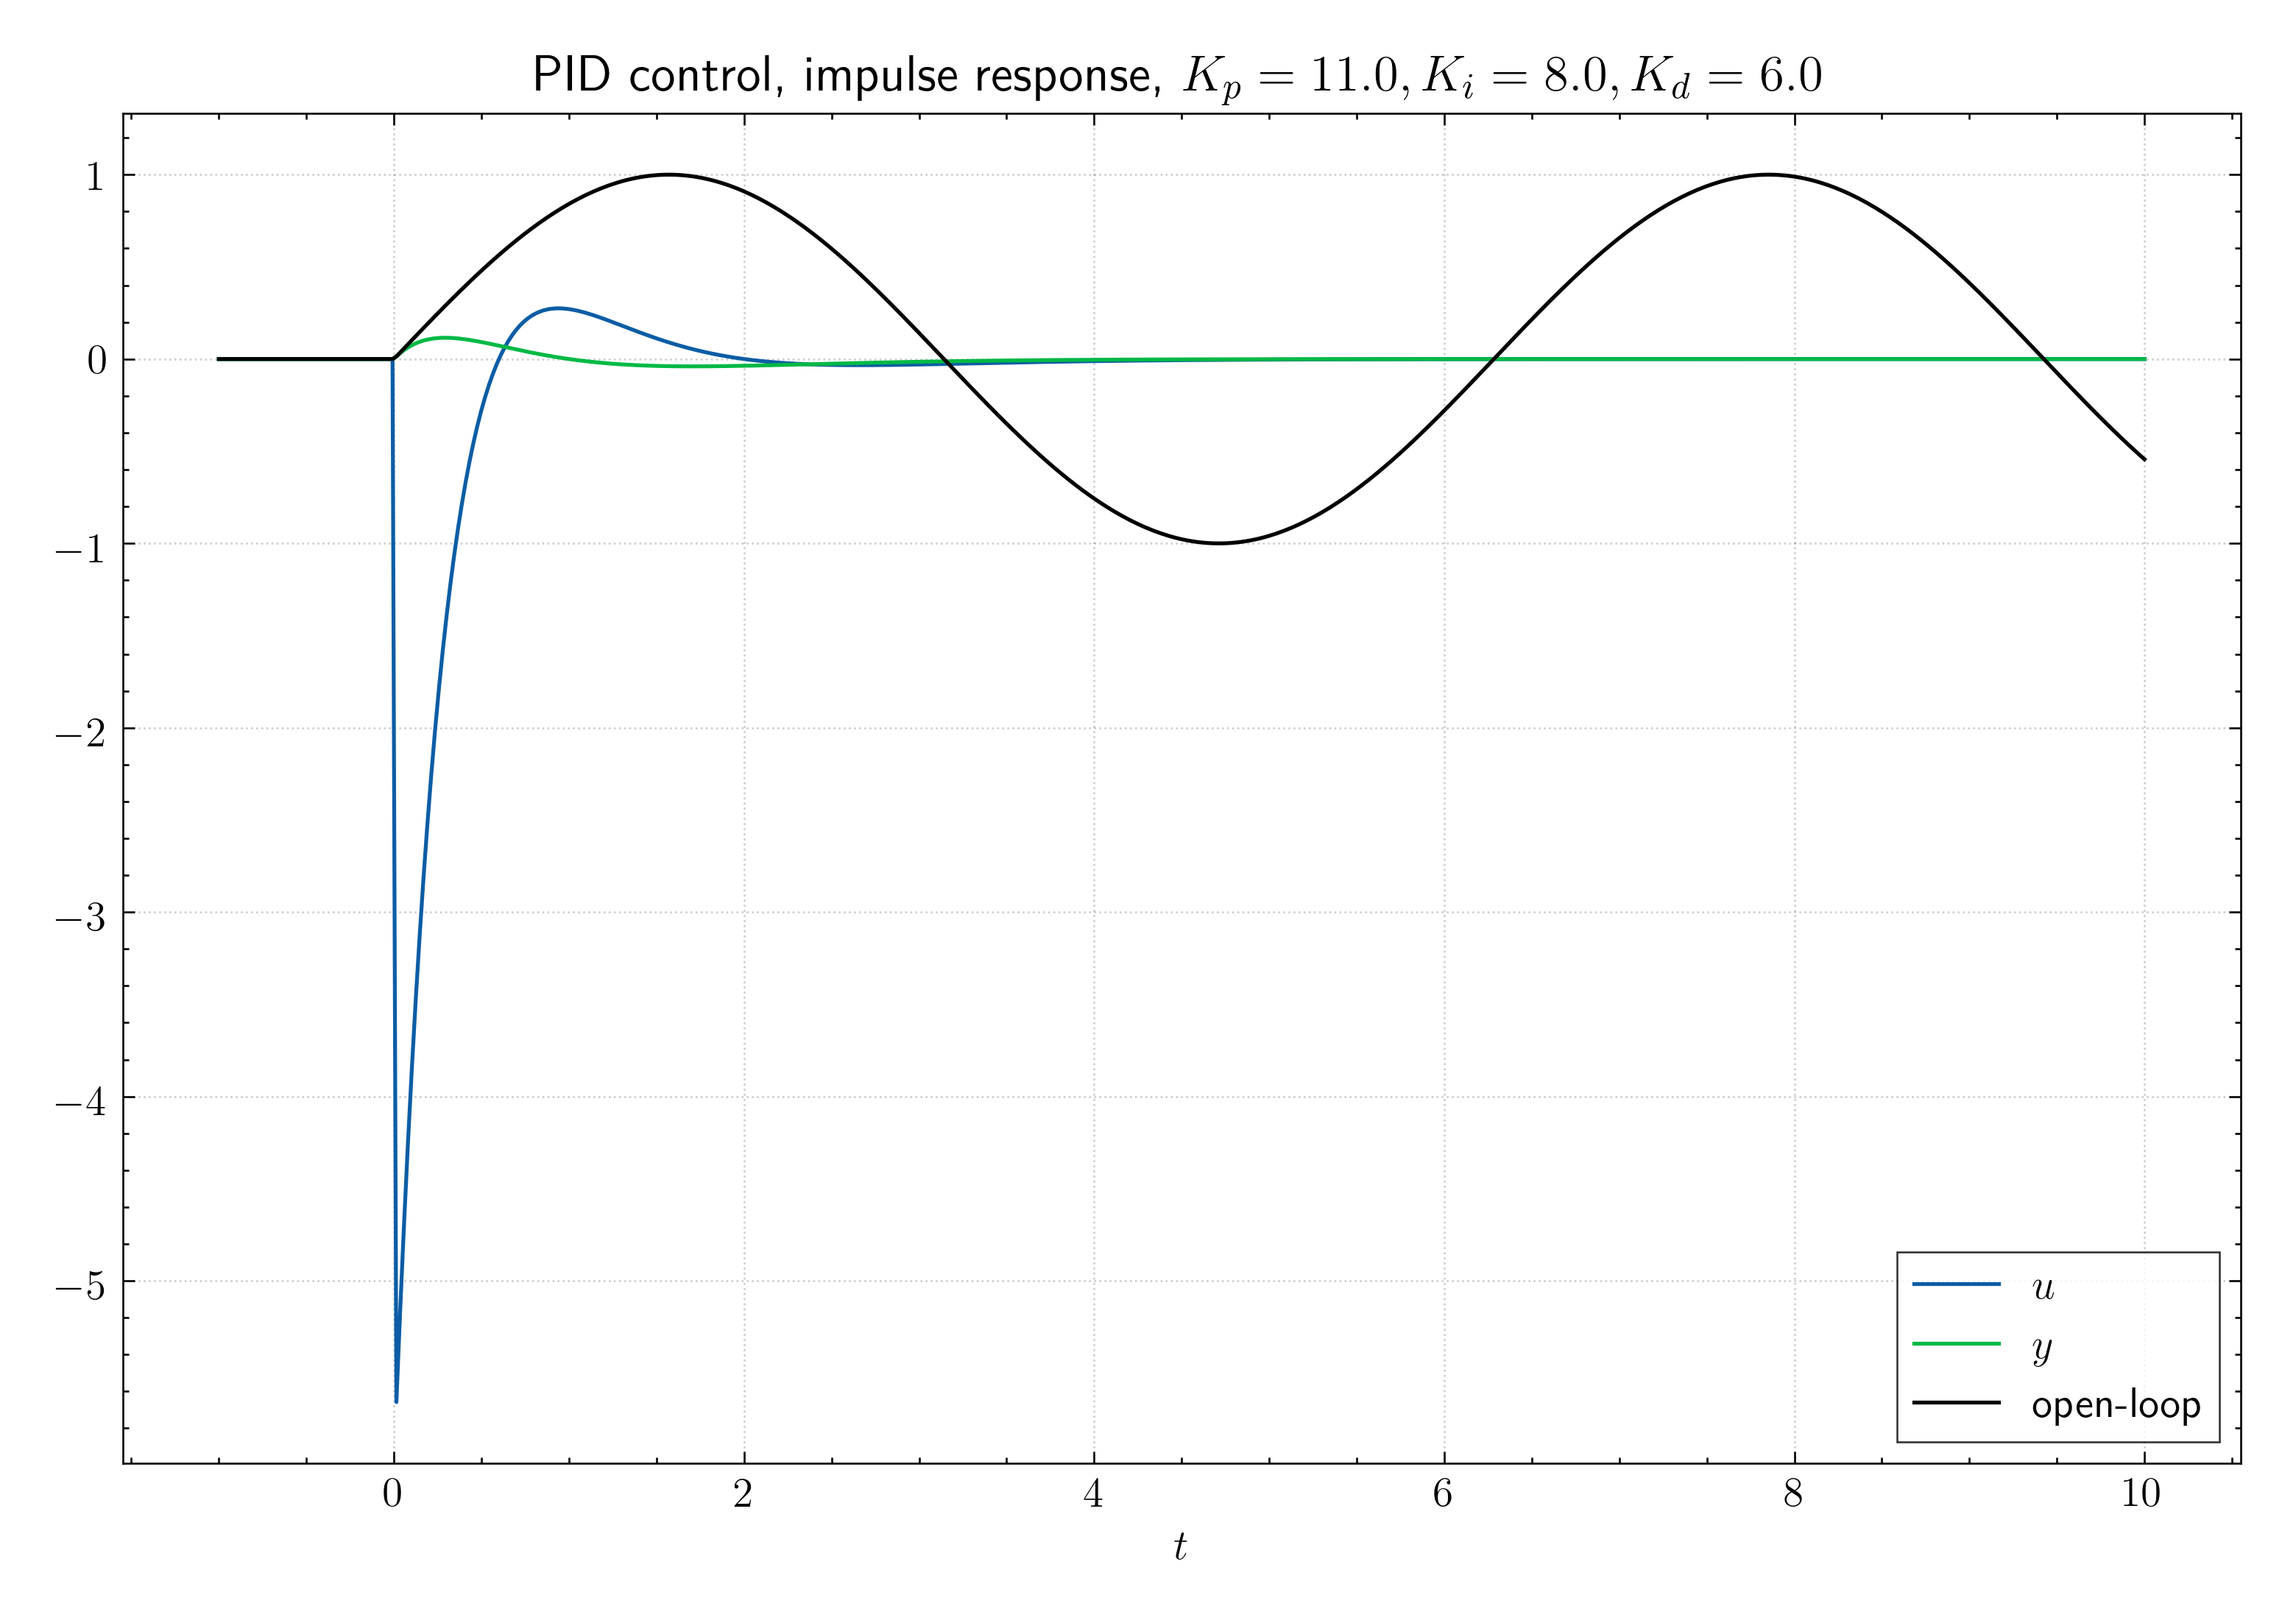

In [8]:
# PID control impulse response
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
d = 1
K = K_p + K_d*s + K_i/s
y = G / (1 + K*G) * d
u = -K * y
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * d, s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, impulse response, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

# Exercise 3.3

In [9]:
from sympy import DiracDelta

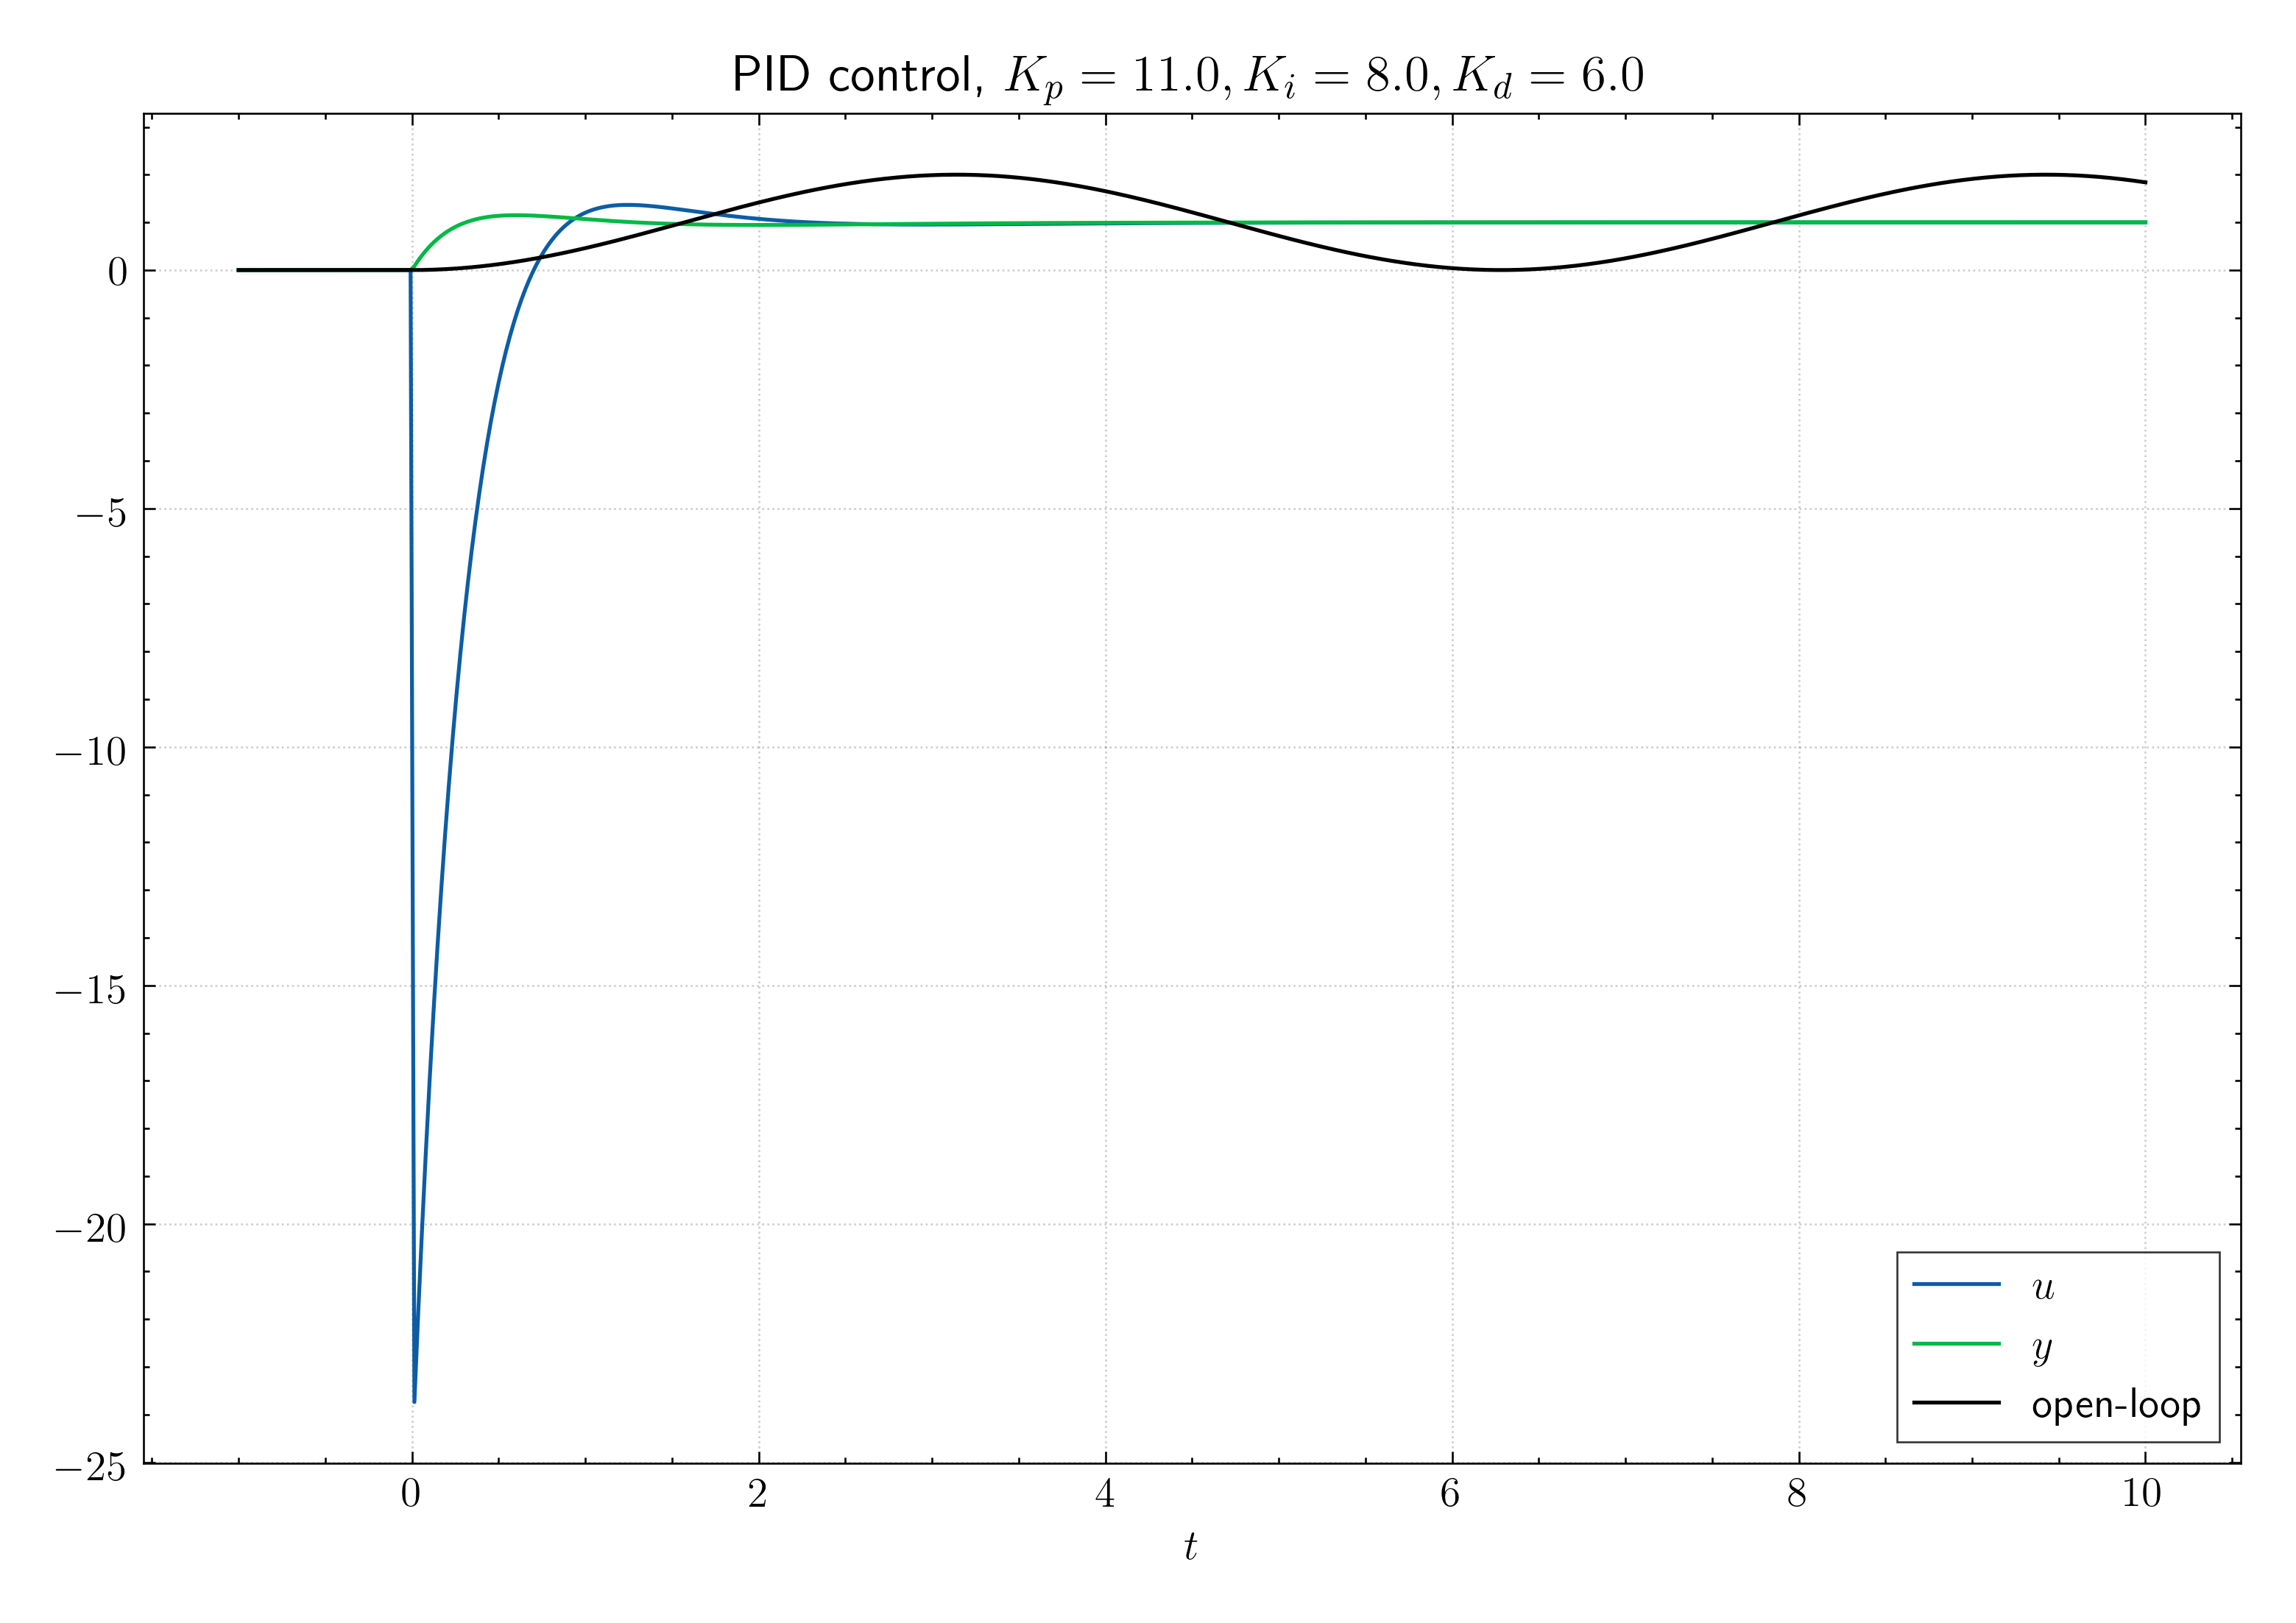

In [10]:
# PID control for tracking
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
r = 1/s
K = K_p + K_d*s + K_i/s
y = G*K / (1 + G*K) * r
u = K / (1 + G*K) * r
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), (u - 3*a*sp.DiracDelta(t)).simplify())  # Dirac delta in action necessary!
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * r, s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

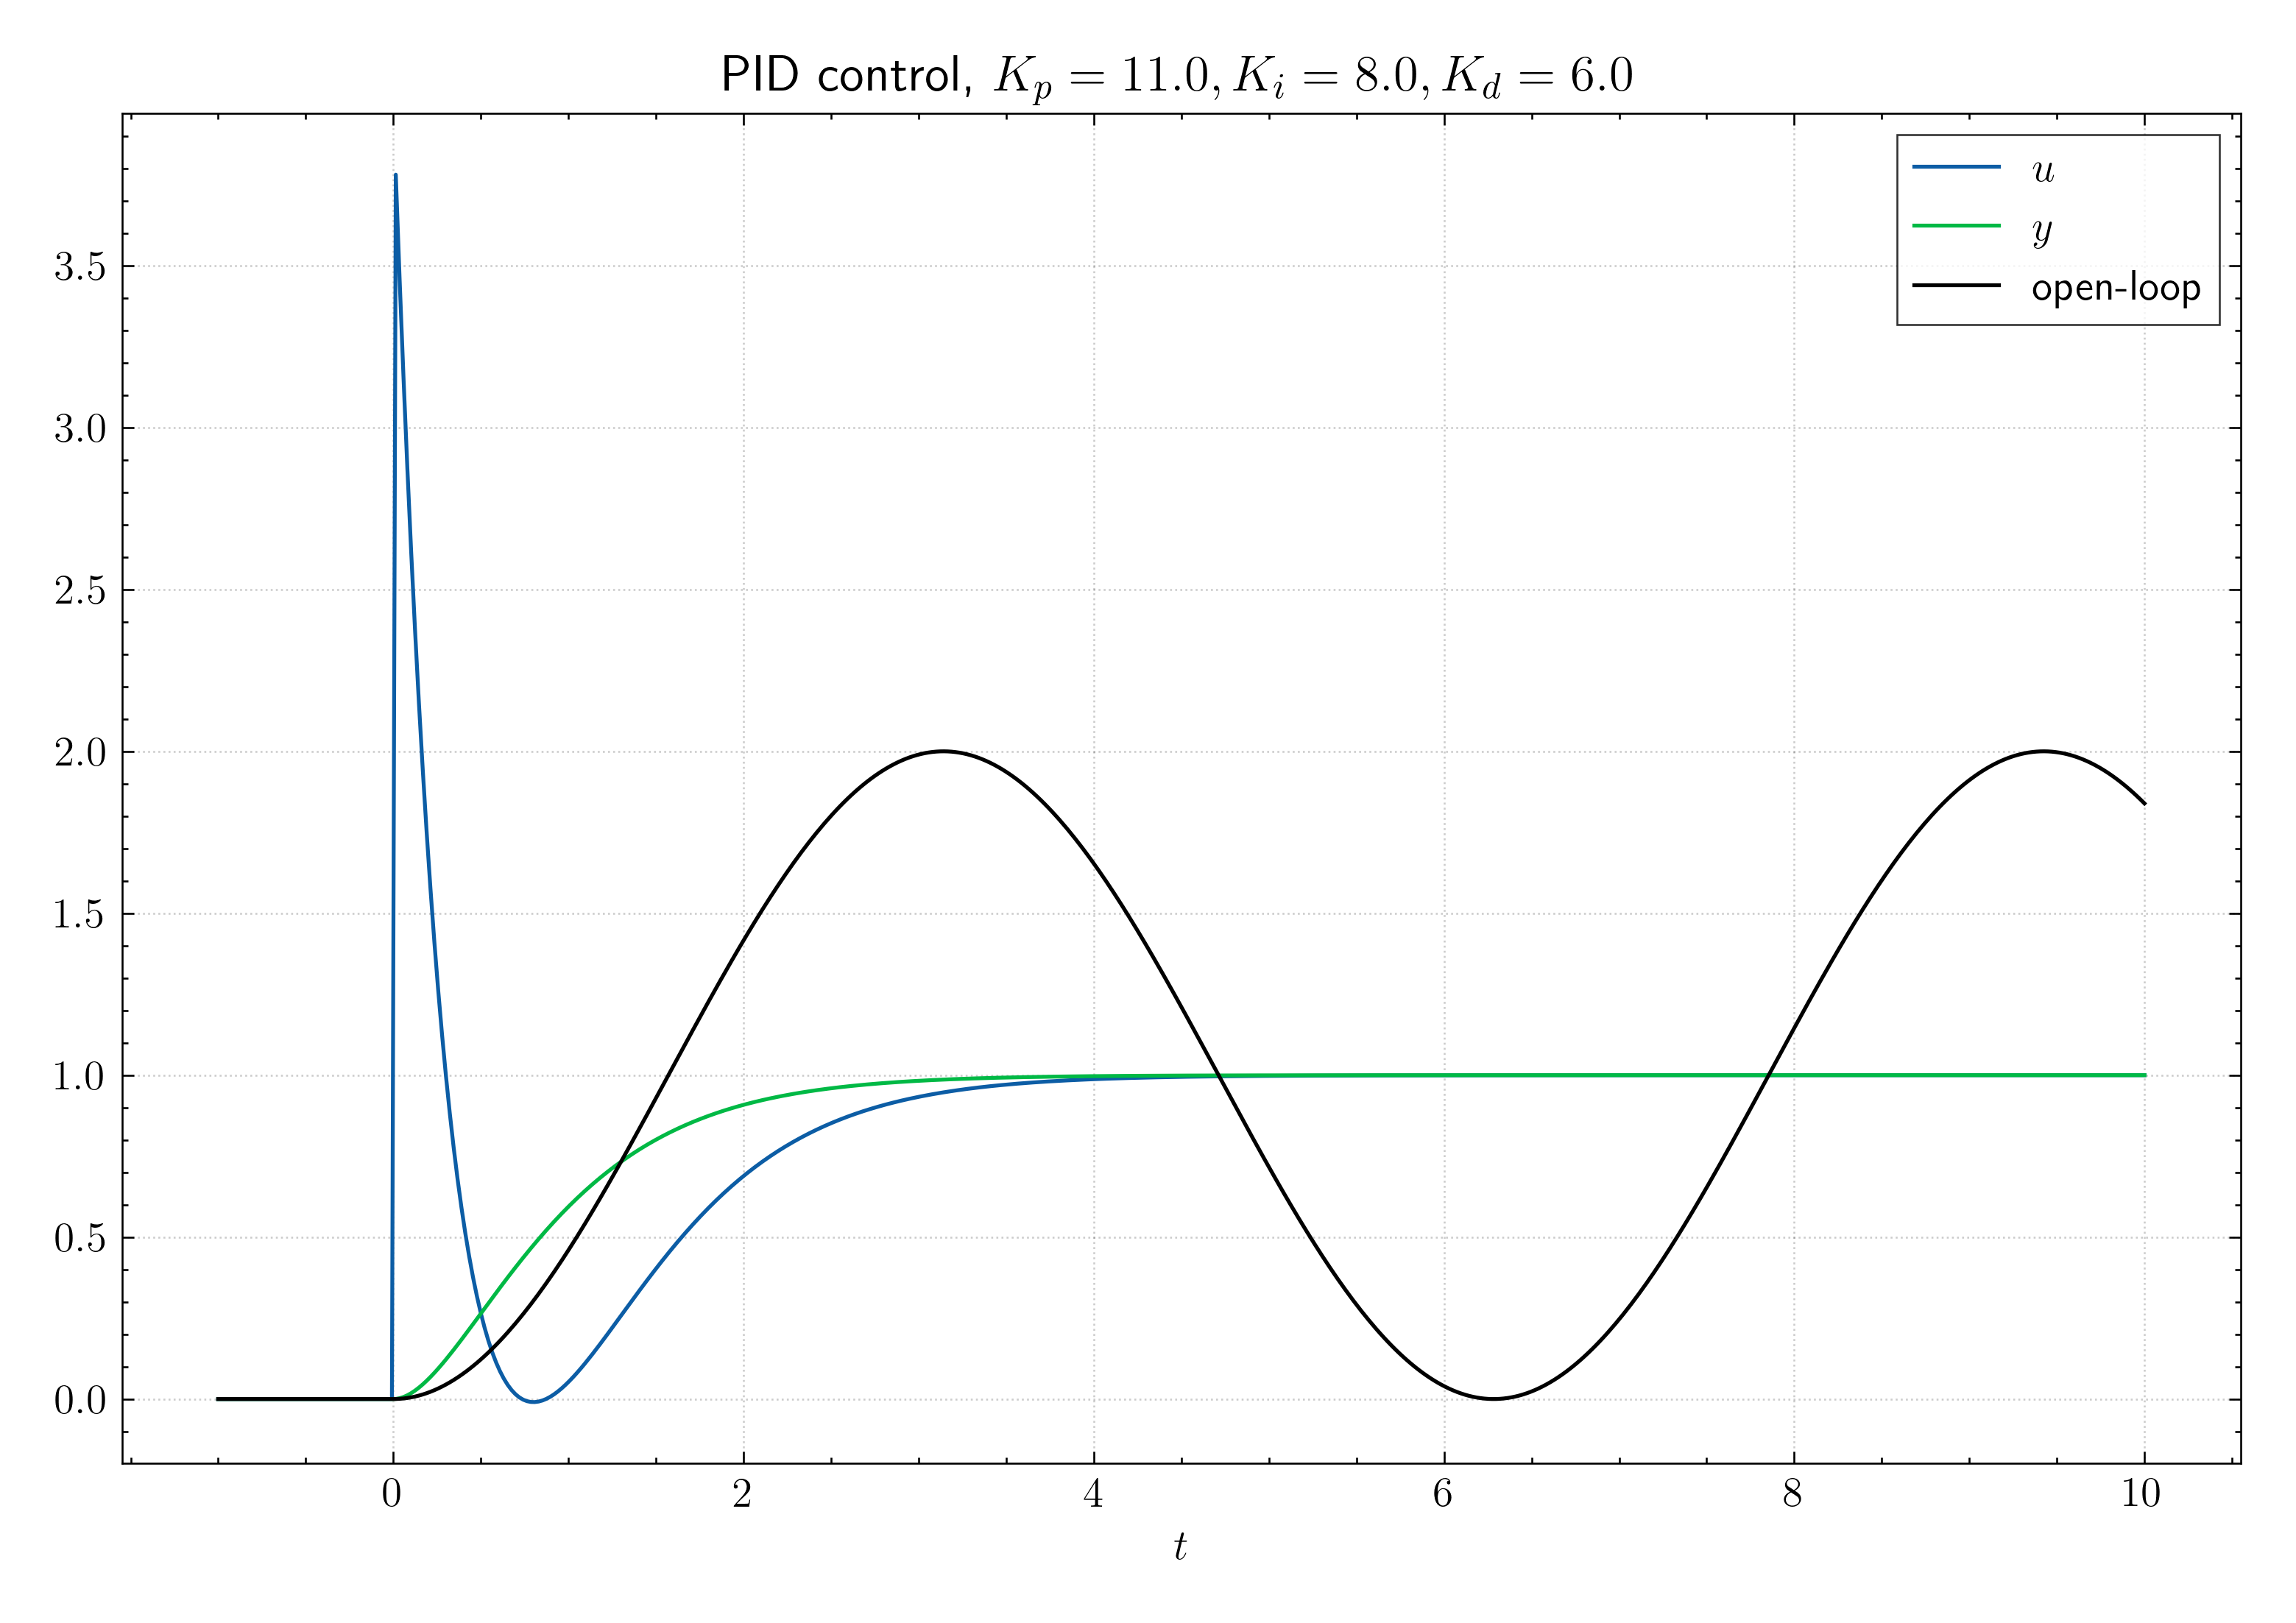

In [11]:
# PID control with feedforward for tracking
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
r = 1/s
K = K_p + K_d*s + K_i/s
S = 1 / (1 + G*K)
T = G*K * S
F = 1 / (T * (1 + s/a)**2)
y = T * F * r
u = K * S * F * r
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * r, s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

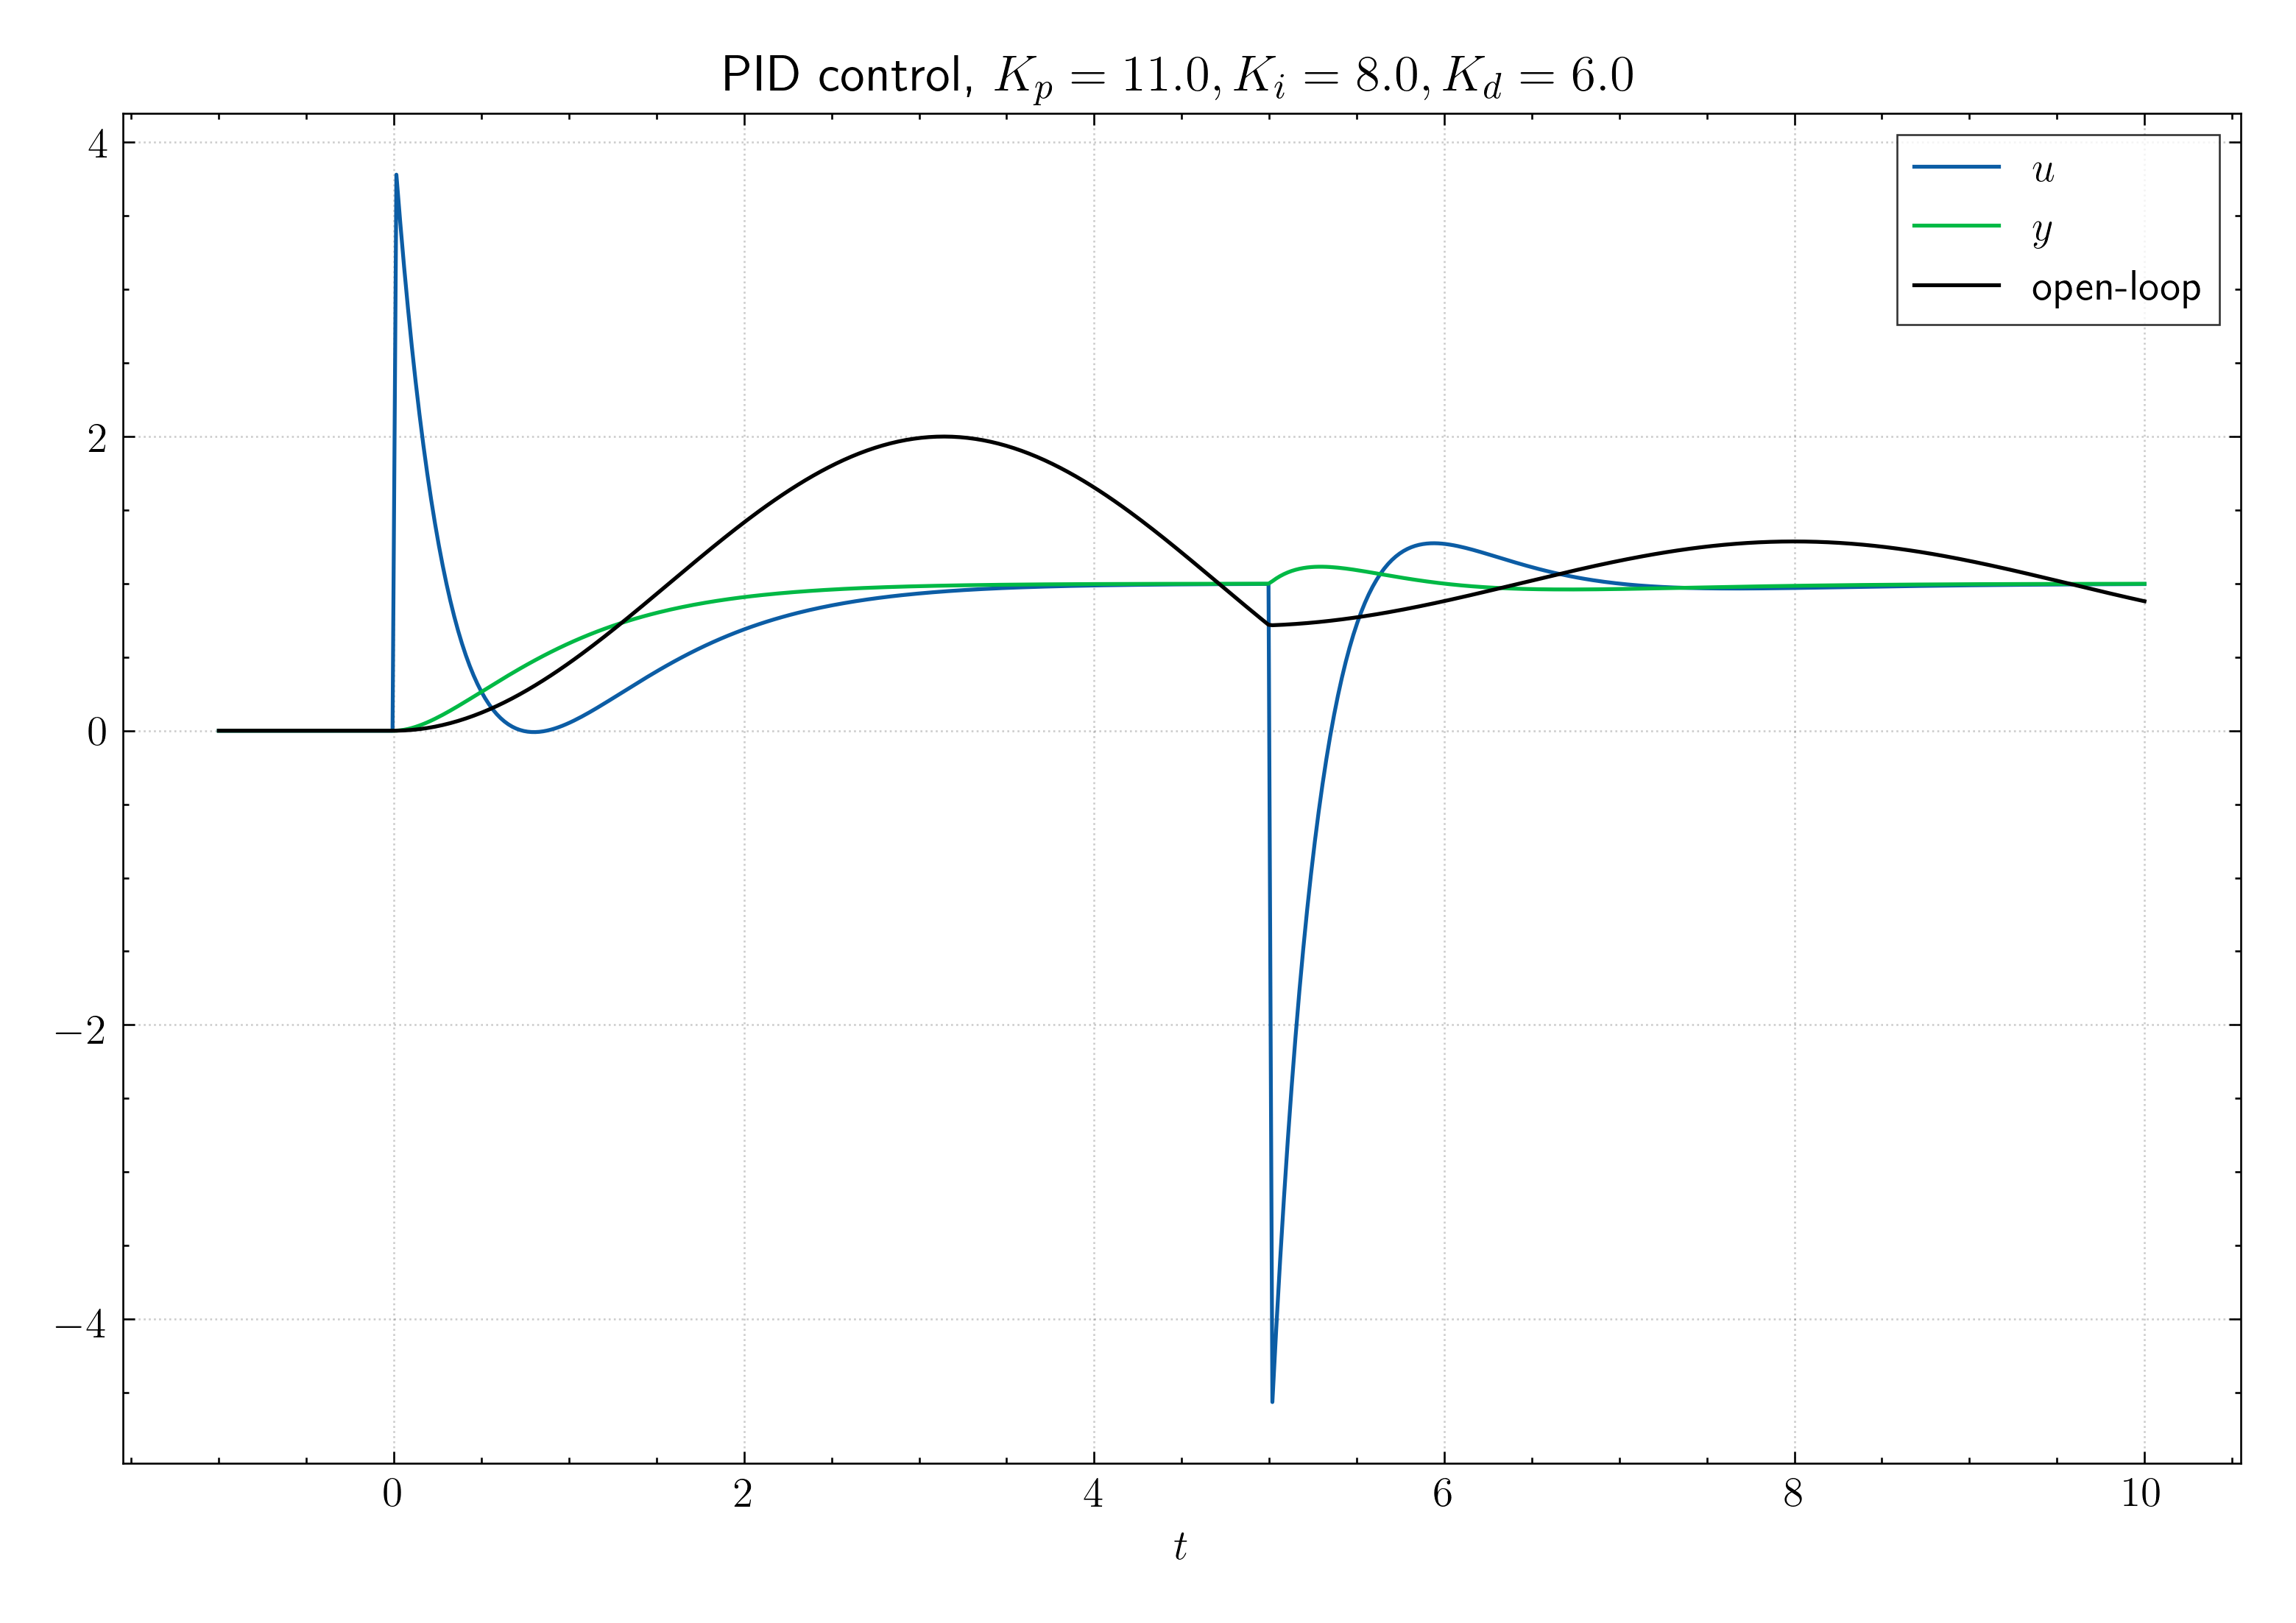

In [12]:
# PID control with feedforward for tracking and disturbance rejection
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
r = 1/s
d = sp.exp(-5*s)
K = K_p + K_d*s + K_i/s
S = 1 / (1 + G*K)
T = G*K * S
F = 1 / (T * (1 + s/a)**2)
y = T*F*r + G*S*d
u = K * S * (F*r - G*d)
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * (r + d), s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

# Exercise 3.4

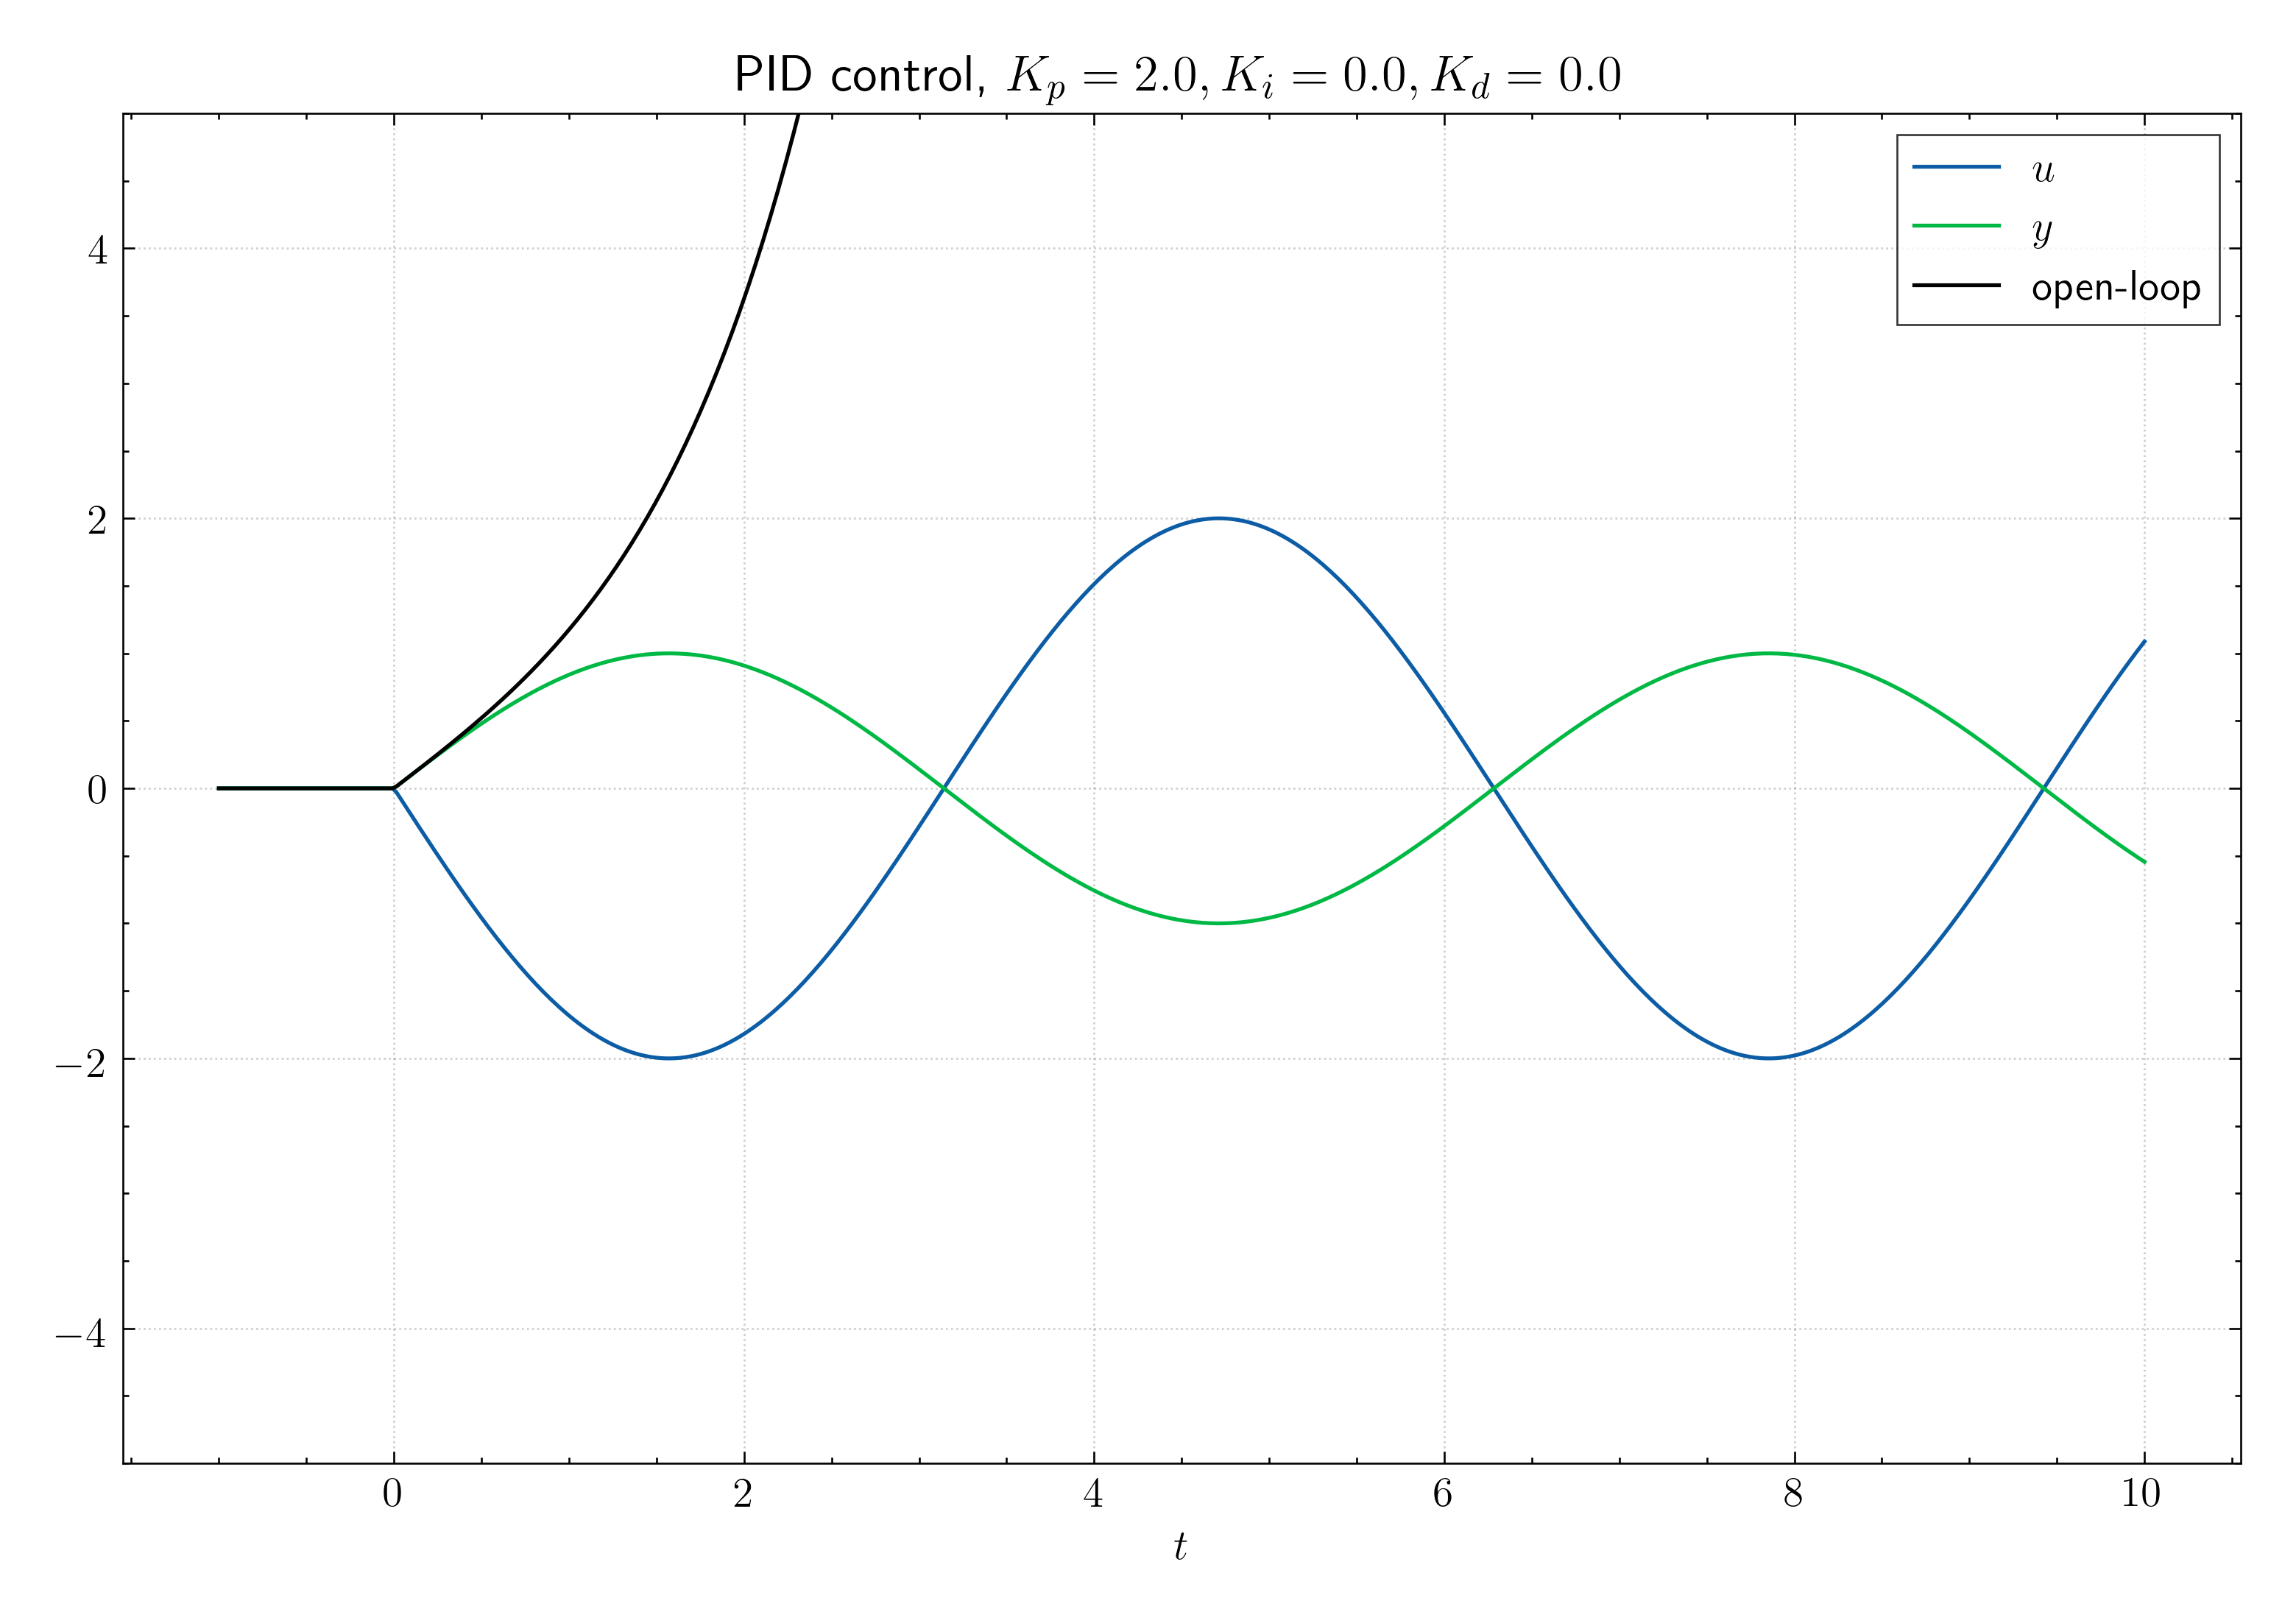

In [13]:
# PID control with feedforward for tracking and disturbance rejection
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
# params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
params = {K_p: a, K_d: sp.S(0), K_i: sp.S(0)}
G = 1/(s**2 - 1)
r = 0
d = 1
K = K_p + K_d*s + K_i/s
S = 1 / (1 + G*K)
T = G * K * S
y = T*r + G*S*d
u = K * S * (r - G*d)
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * (r + d), s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    ax.set_ylim(-5, 5)
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

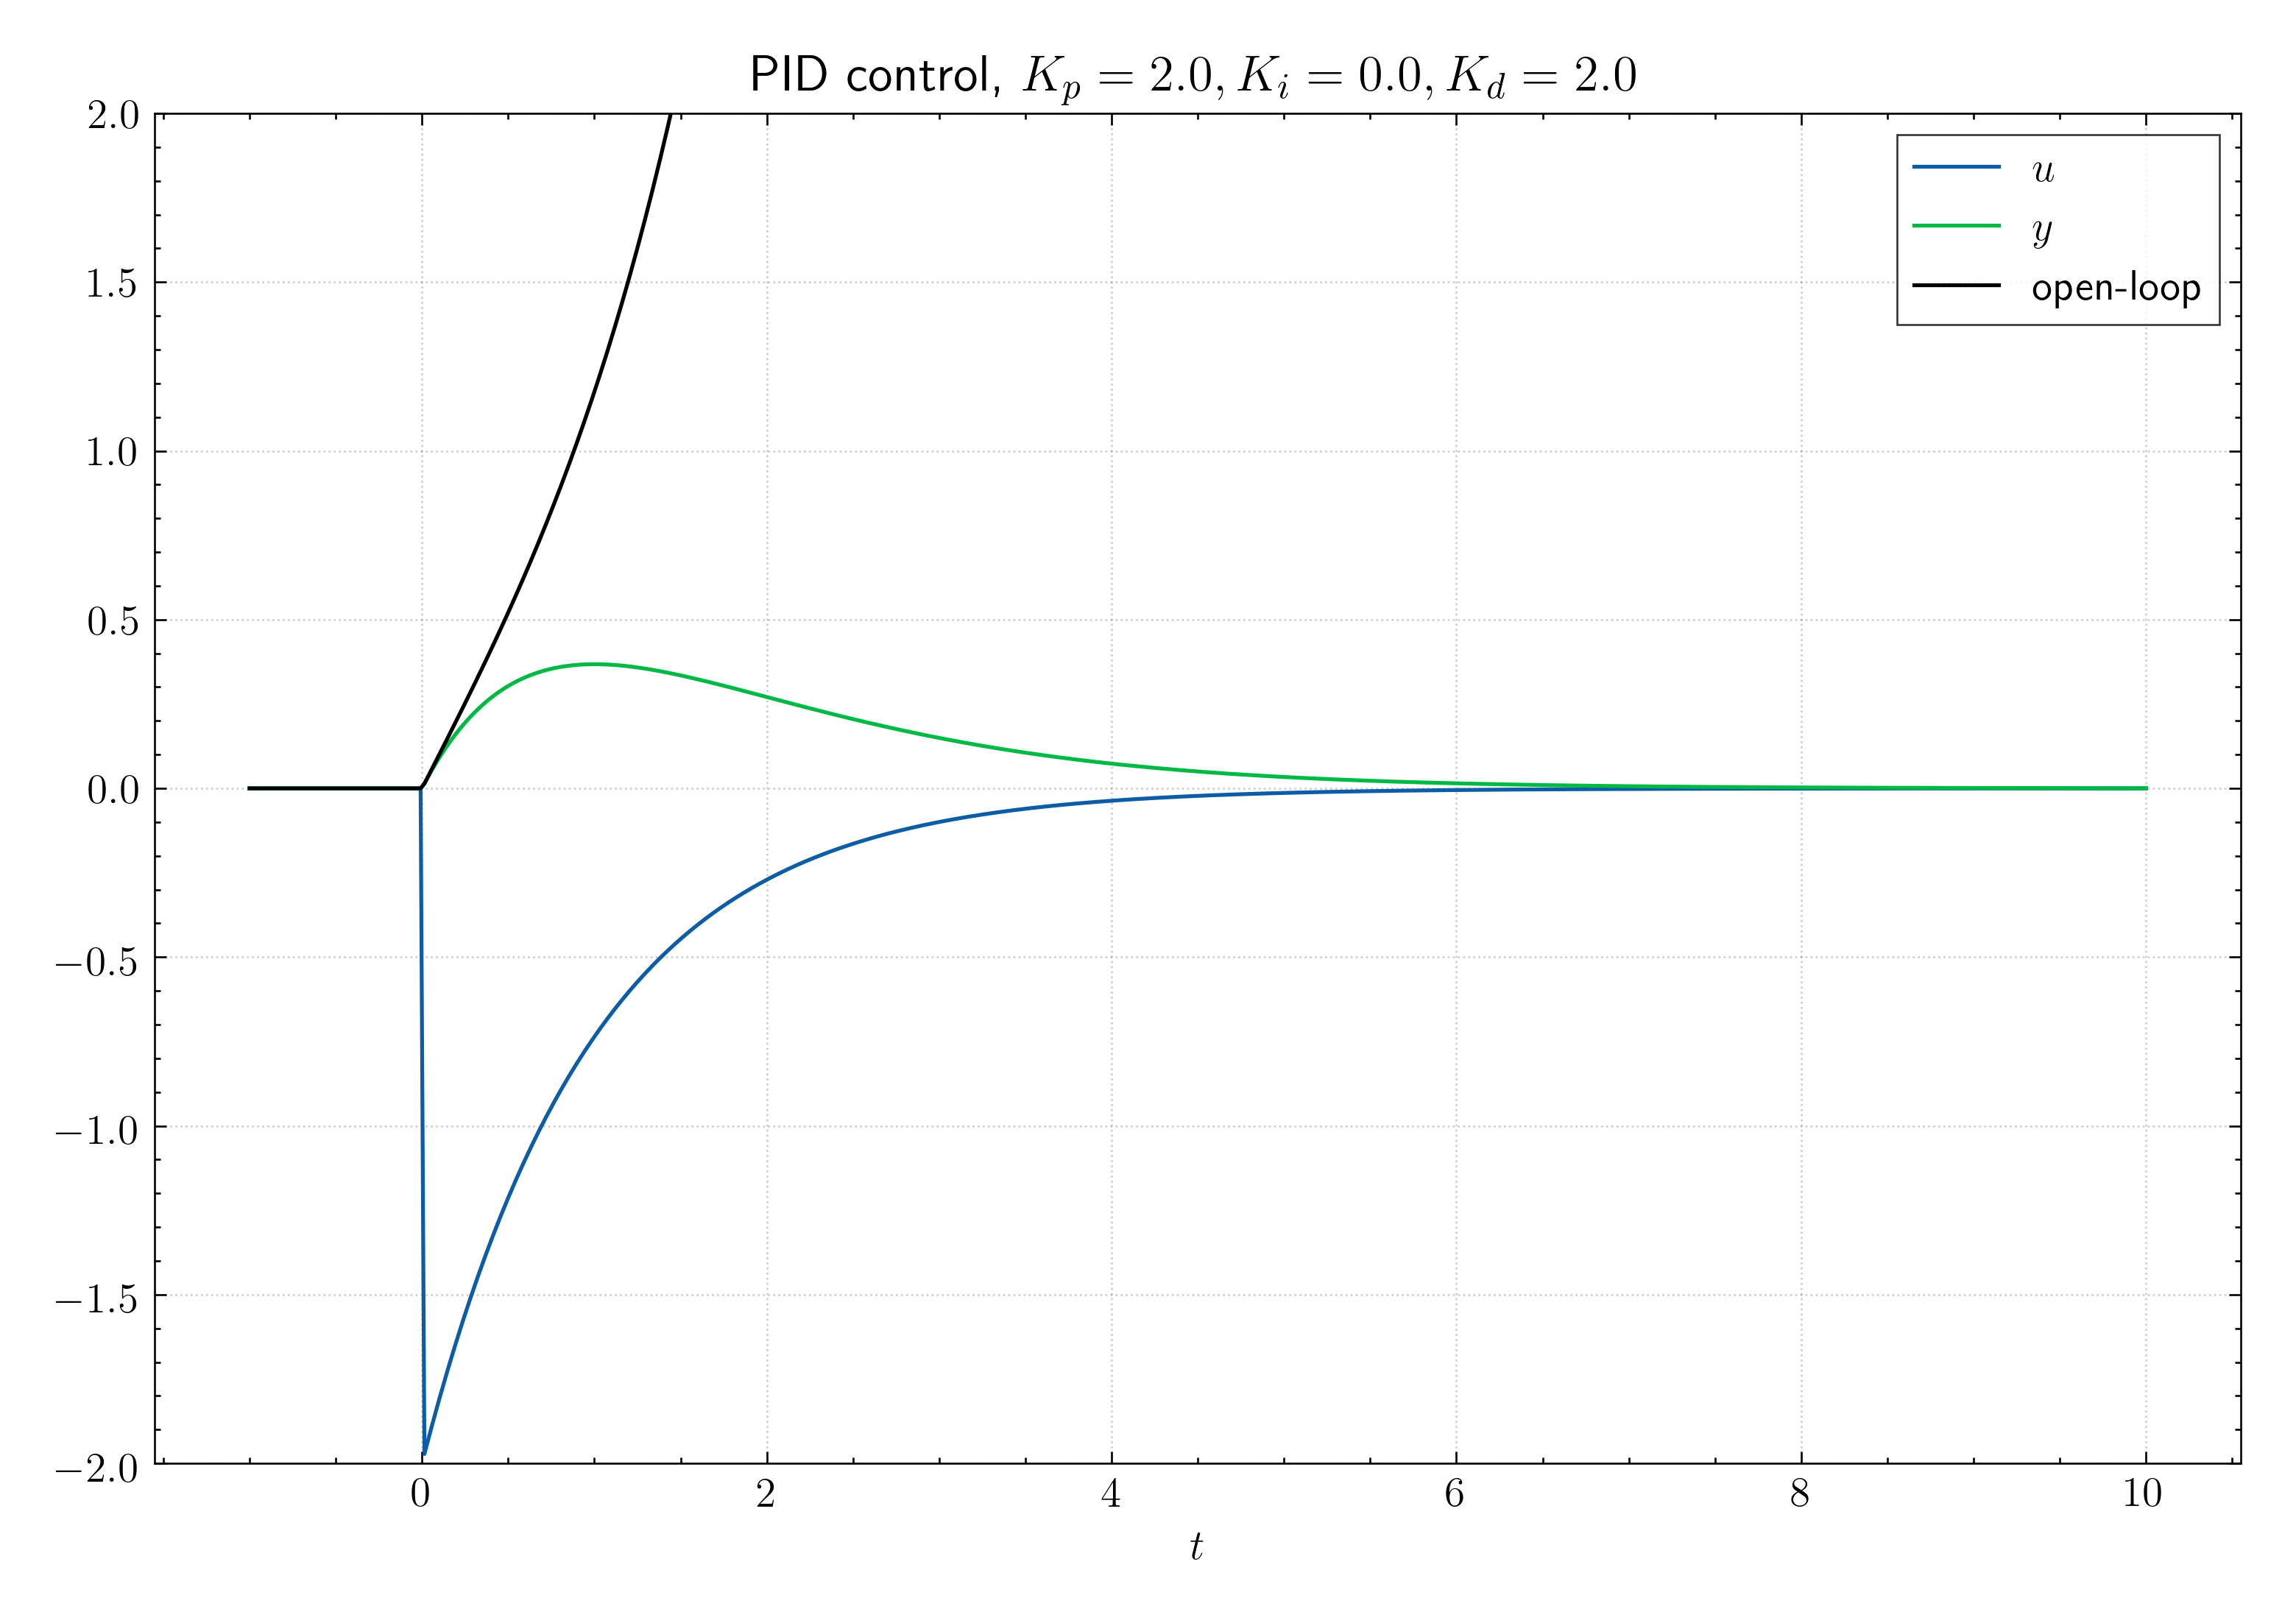

In [14]:
# PID control with feedforward for tracking and disturbance rejection
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
G = 1/(s**2 - 1)
r = 0
d = 1
K = K_p + K_d*s + K_i/s
params = sp.solve((s + a)**2 - (1/G + K), (K_p, K_d, K_i))  # Pole placement
S = 1 / (1 + G*K)
T = G * K * S
y = T*r + G*S*d
u = K * S * (r - G*d)
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * (r + d), s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    ax.set_ylim(-2, 2)
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=1)

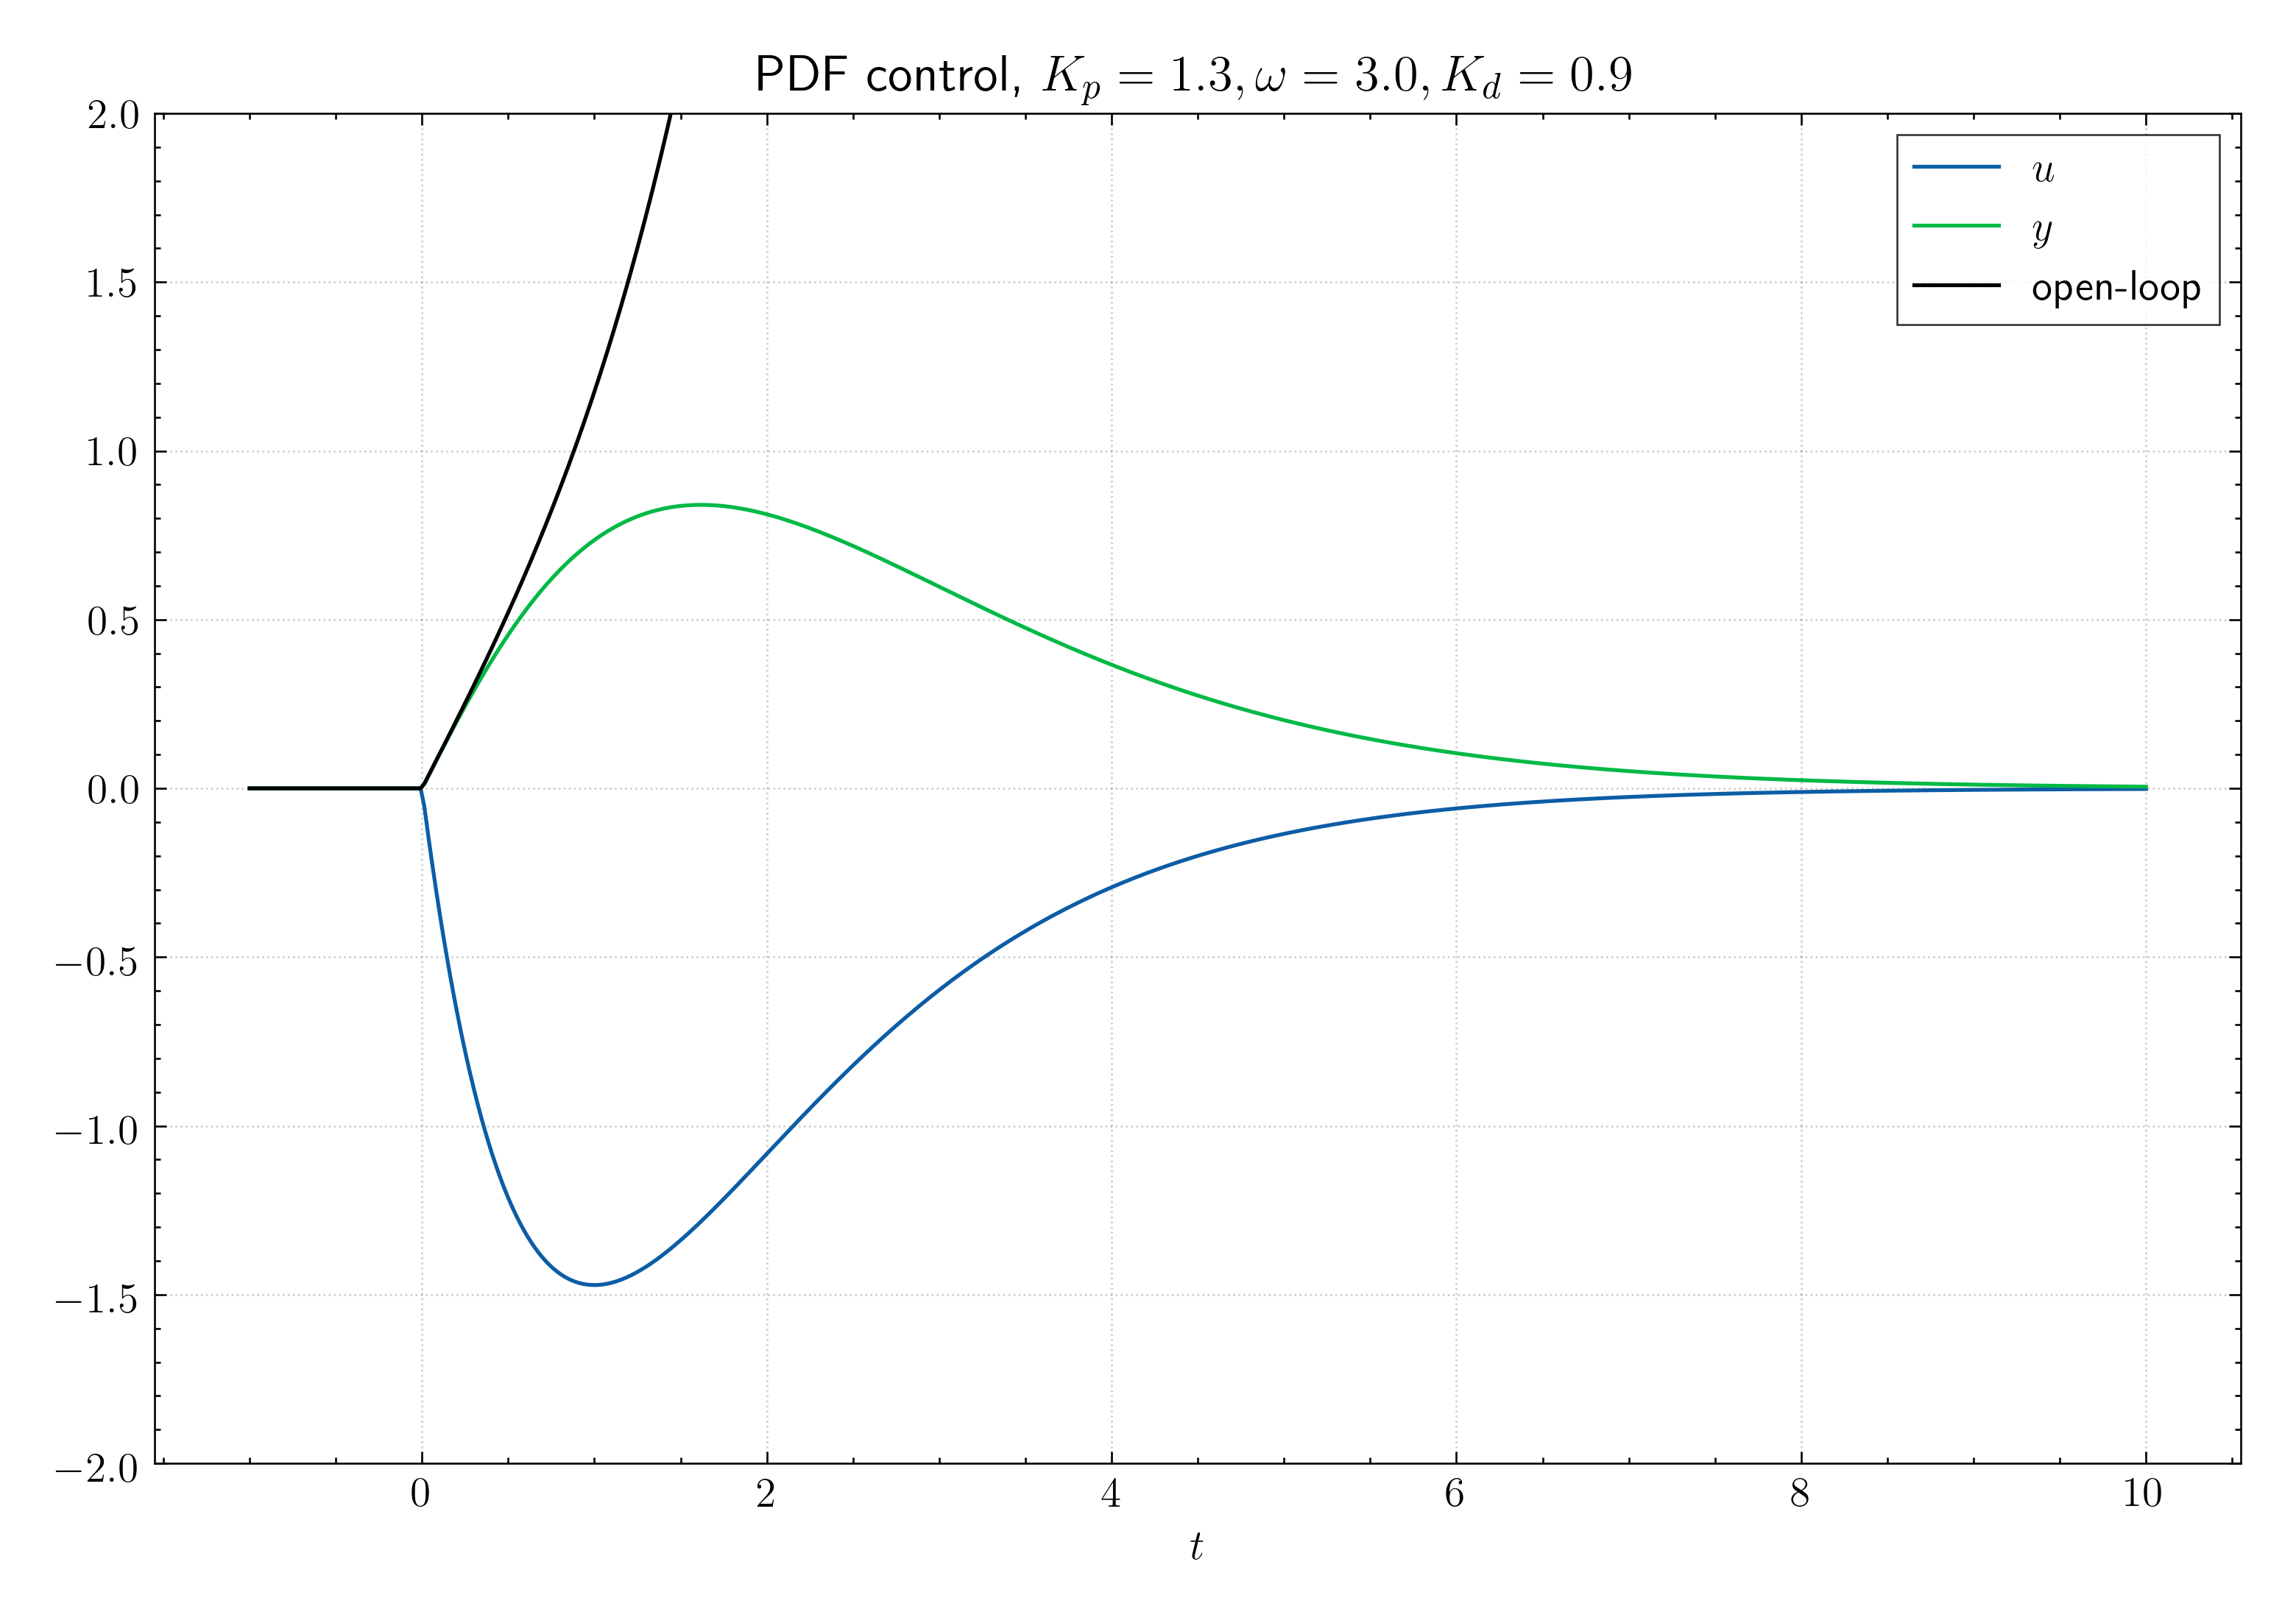

In [15]:
# PID control with feedforward for tracking and disturbance rejection
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_d, omega, a = sp.S('t, s, K_p, K_d, omega, a')
G = 1/(s**2 - 1)
r = 0
d = 1
K = K_p + K_d*s/(1 + s/omega)
params = sp.solve((s + a)**3 - (K_d*omega*s + K_p*omega + K_p*s + omega*s**2 - omega + s**3 - s), (K_p, K_d, omega))  # Pole placement
S = 1 / (1 + G*K)
T = G * K * S
y = T*r + G*S*d
u = K * S * (r - G*d)
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * (r + d), s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(fr"PDF control, $K_p = {params_[K_p]:.1f}, \omega = {params_[omega]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    ax.set_ylim(-2, 2)
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=1)

# Exercise 3.5

In [16]:
s = sp.symbols('s')
K_i = sp.symbols('K_i', real=True)
omega = sp.symbols('omega', real=True, positive=True)
G = 1 / (1 + s)**2
K = K_i / s
L = (G*K).subs(s, sp.I*omega)
T = G*K / (1 + G*K)

In [17]:
Kis = np.logspace(-2, 1, 100)
images = []
lines = []
for i, K in enumerate(tqdm(Kis)):
    f = sp.lambdify(s, T.subs(K_i, Kis[i]))
    cplot.plot(f, (-4, 2, 500), (-3, 3, 500))
    ax = plt.gcf().get_axes()[0]
    images.append(ax.images[0].get_array())
    lines.append([c.get_segments() for c in ax.collections])
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

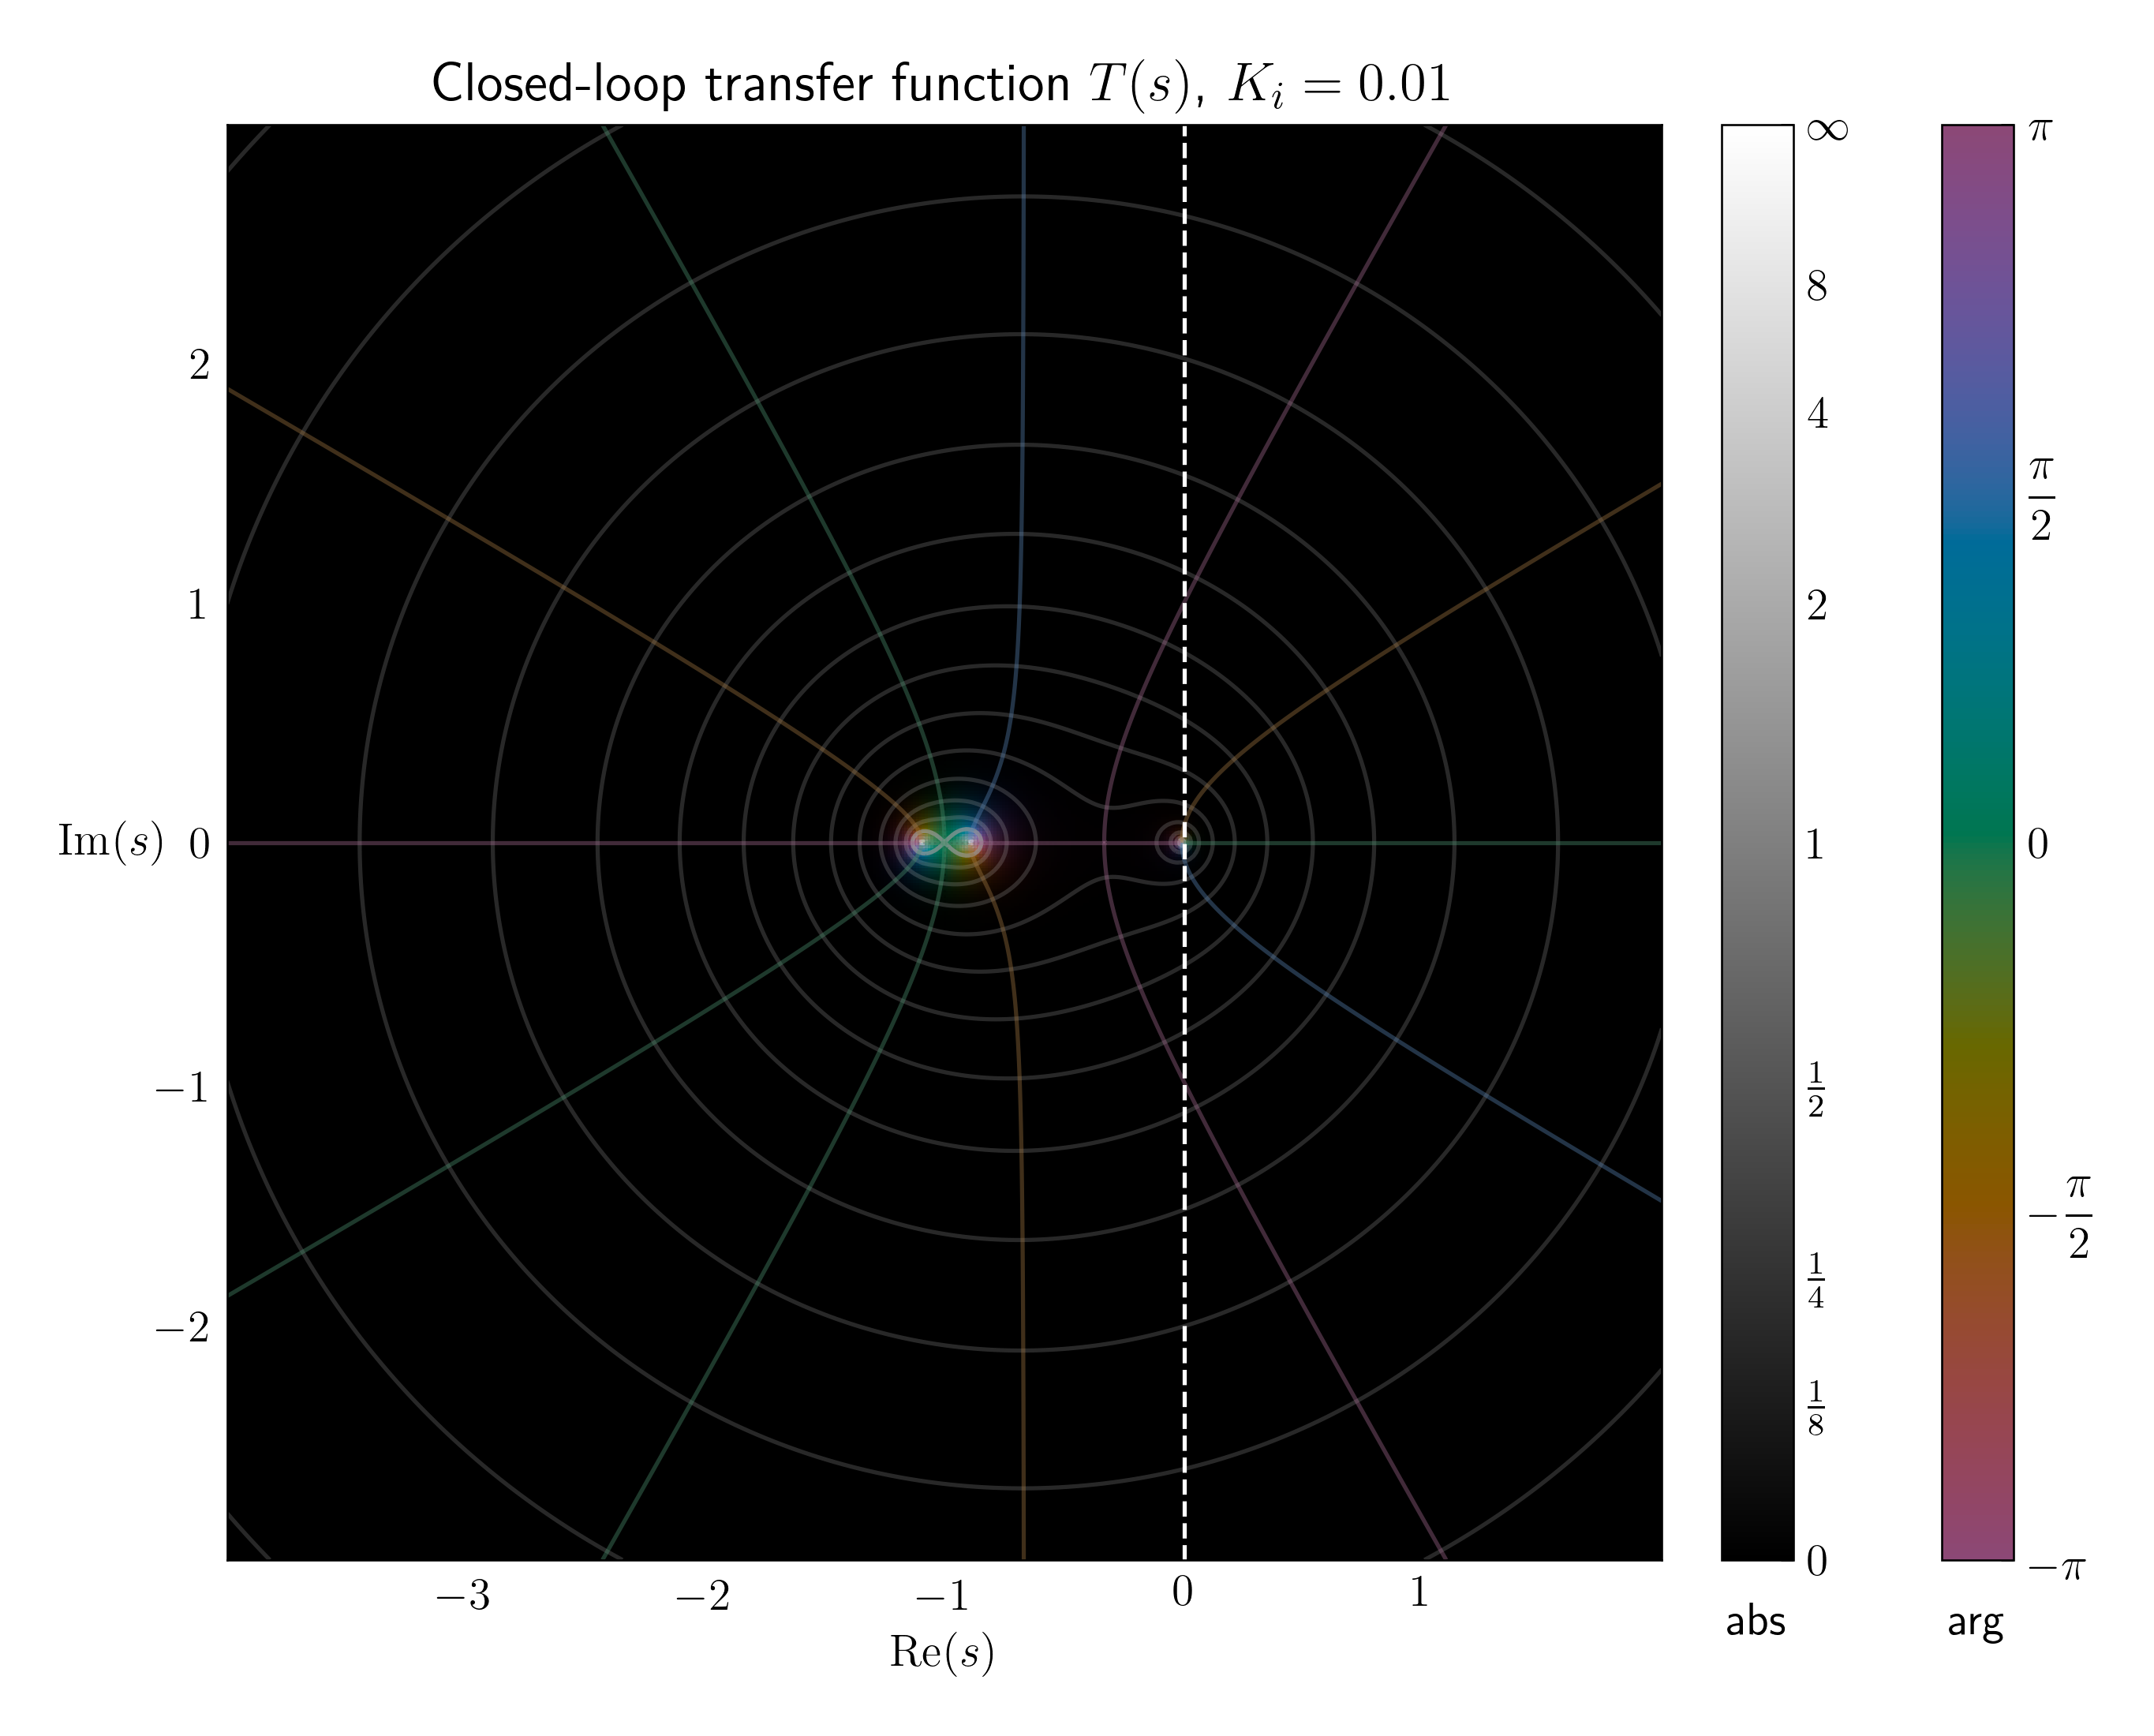

In [18]:
dpi = plt.rcParams["savefig.dpi"]
plt.rcParams["savefig.dpi"] = 120
f = sp.lambdify(s, T.subs(K_i, 1))
cplot.plot(f, (-4, 2, 500), (-3, 3, 500))
fig = plt.gcf()
fig.get_axes()[1].set_yticklabels(
    [x if '$' in x.get_text() else f'${x.get_text()}$' for x in plt.gcf().get_axes()[1].get_yticklabels()])
ax = fig.get_axes()[0]
ax.set_title(f"Closed-loop transfer function $T(s)$, $K_i = {1:.2f}$")
ax.set_xlabel(r"$\operatorname{Re}(s)$")
ax.set_ylabel(r"$\operatorname{Im}(s)$")
ax.axvline(0, c='w', ls='--')
im = ax.images[0]
cs = ax.collections

def update(i):
    ax.set_title(f"Closed-loop transfer function $T(s)$, $K_i = {Kis[i]:.2f}$")
    im.set_array(images[i])
    for j, c in enumerate(cs):
        c.set_segments(lines[i][j])
    return im, *cs

ani = FuncAnimation(fig, update, frames=list(range(len(Kis))) + list(range(len(Kis)))[::-1], interval=30)
ani.save('ex-03-05.mp4', dpi=dpi)
ani = ani.to_html5_video()
plt.show()
plt.rcParams["savefig.dpi"] = dpi

In [19]:
HTML(ani)

In [20]:
sp.S(str(T.factor()).split('/')[1]).subs(K_i, 2).factor()  # Denominator of T

K_i + s**3 + 2*s**2 + s

In [21]:
sp.S(str(T.factor()).split('/')[1]).subs(K_i, 0).factor()  # Denominator of T

K_i + s**3 + 2*s**2 + s

In [22]:
sp.S(str(T.factor()).split('/')[1]).subs(K_i, sp.S(4)/27).factor()  # Denominator of T

K_i + s**3 + 2*s**2 + s

In [23]:
omega_ = sp.solve(sp.im(L), omega)[0]
1/abs(L).subs(omega, omega_)

2/Abs(K_i)

In [24]:
pms = np.zeros(100)
Ks = np.linspace(1e-6, 2 - 1e-6, 100)
for i, k in enumerate(tqdm(Ks)):
    omega_ = next(iter(sp.solveset(abs(L).subs(K_i, k) - 1, omega, domain=sp.Reals)))
    pms[i] = ((sp.pi + sp.arg(L.subs(omega, omega_).subs(K_i, 1))) * 180 / sp.pi).evalf()

  0%|          | 0/100 [00:00<?, ?it/s]

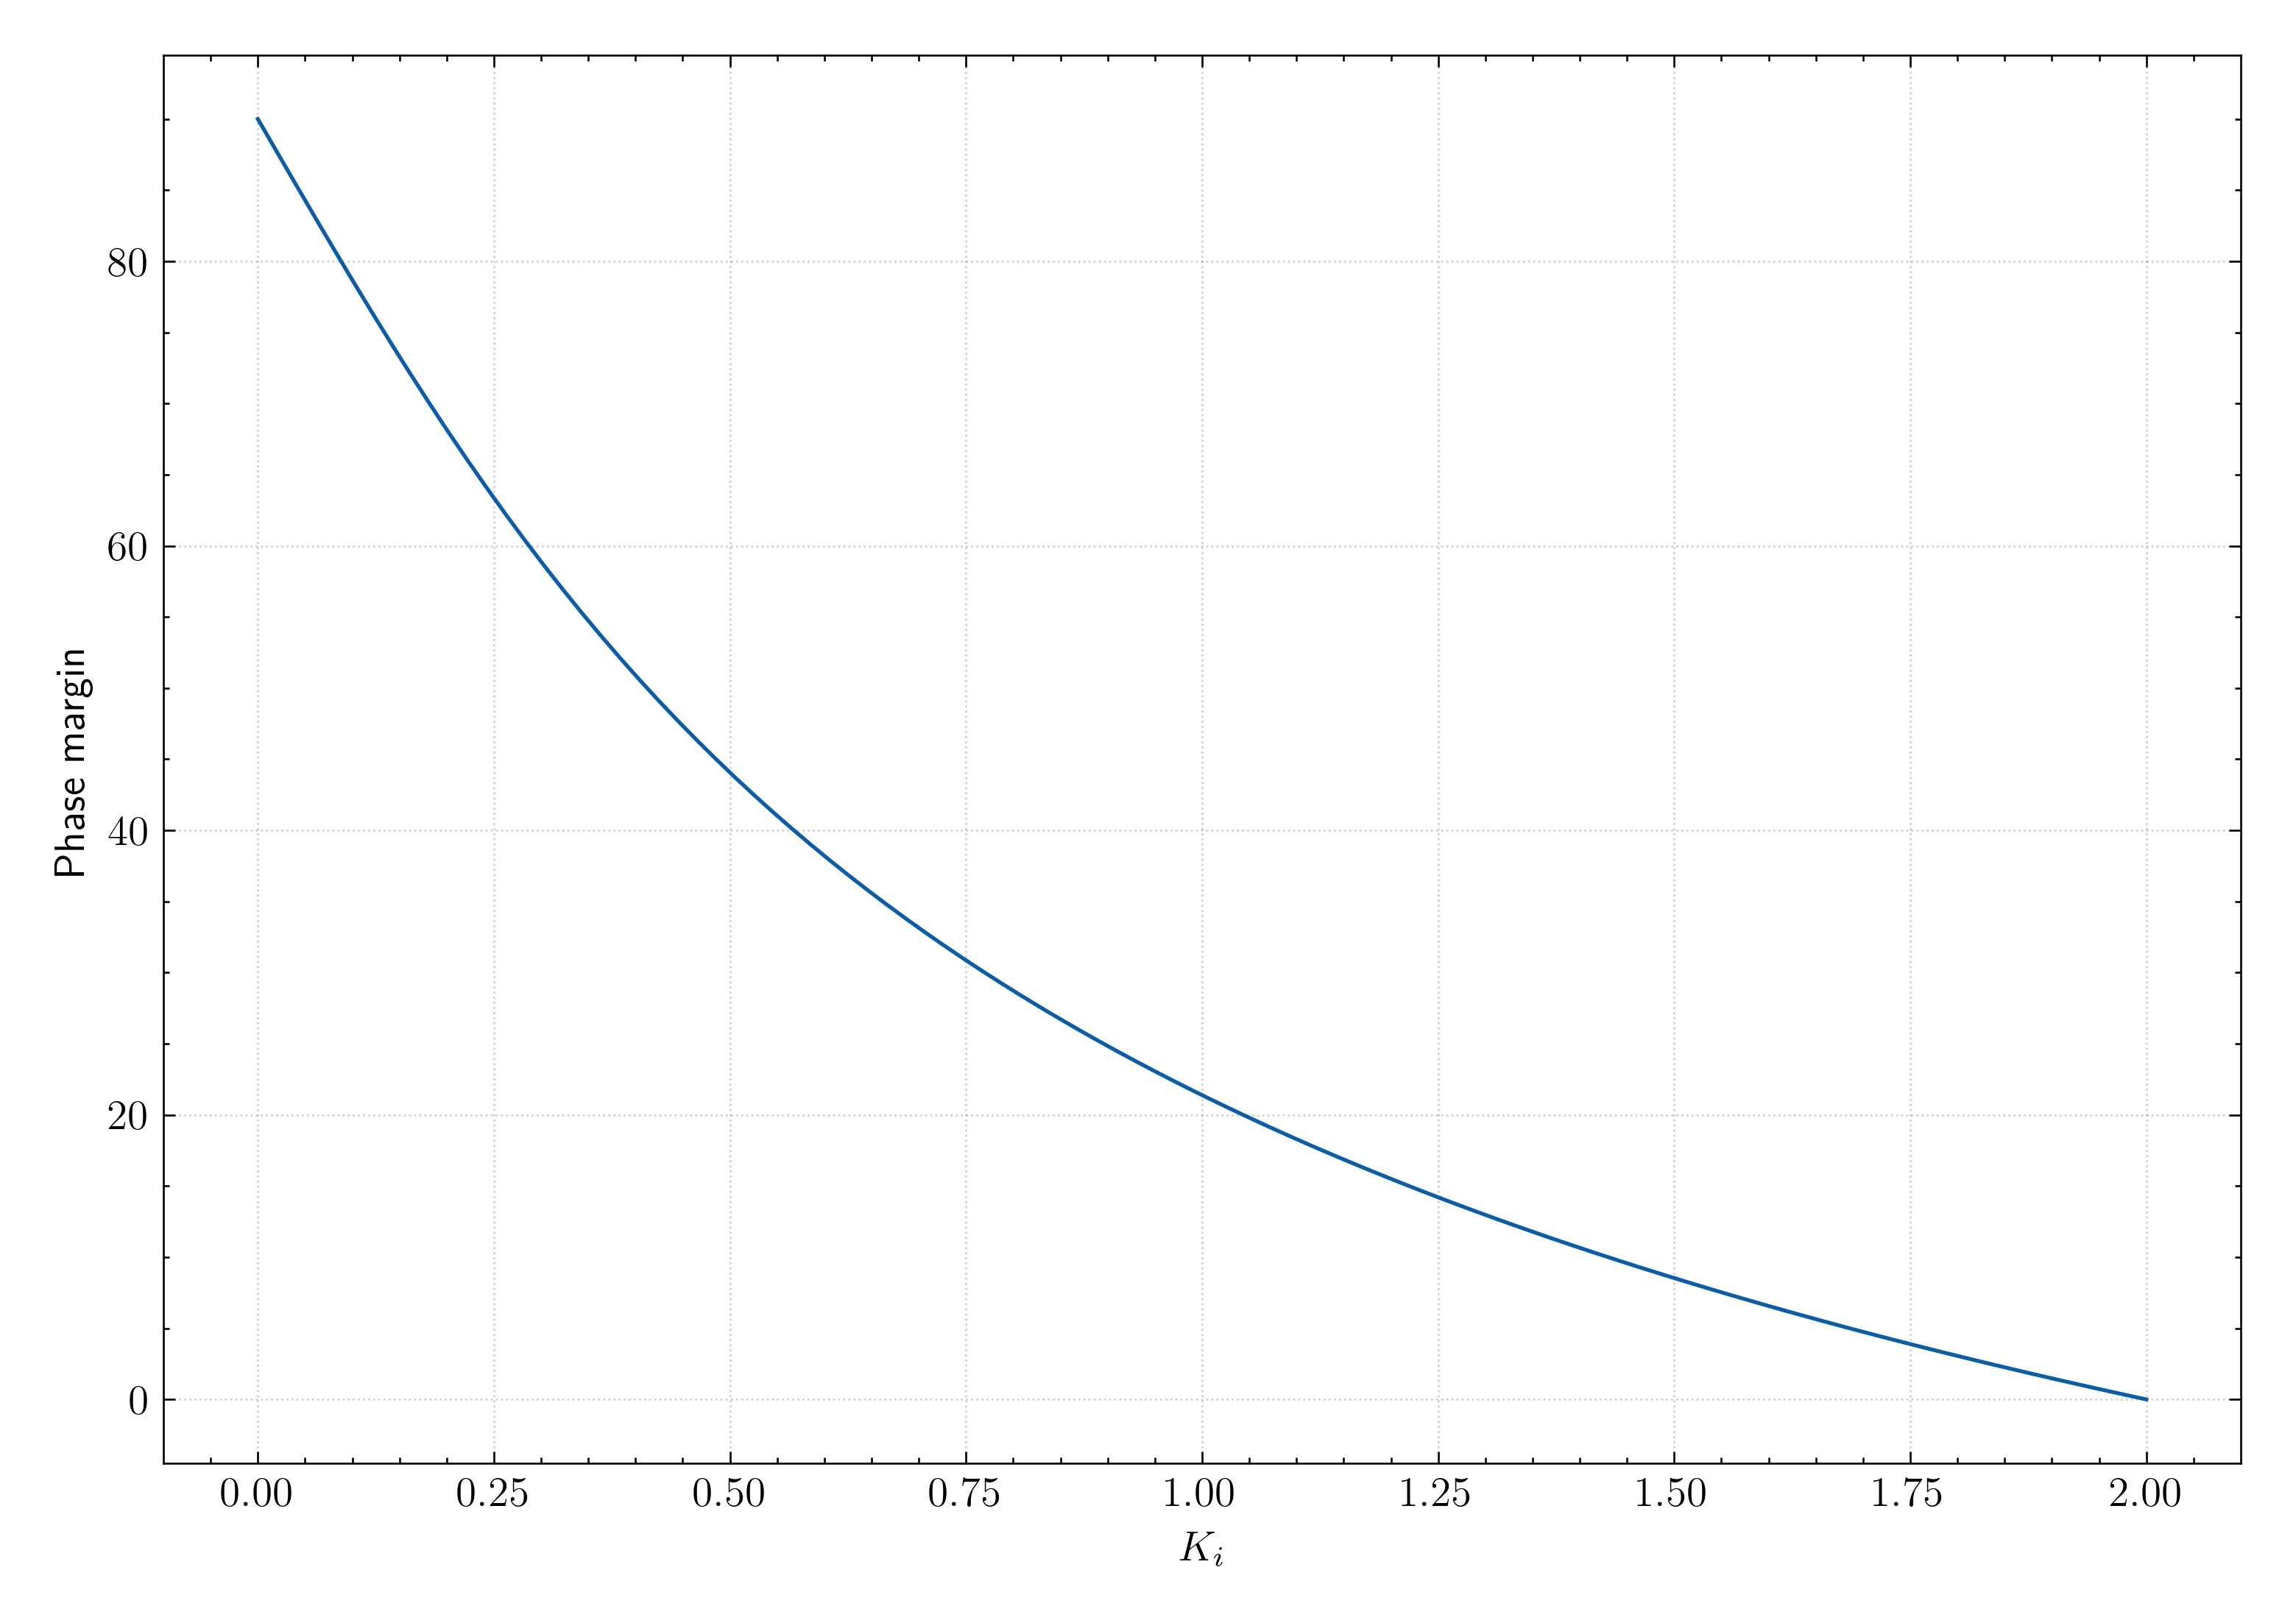

In [25]:
fig, ax = plt.subplots()
ax.plot(Ks, pms)
ax.set_xlabel("$K_i$")
ax.set_ylabel("Phase margin")
plt.show()

# Exercise 3.6

In [1]:
import sympy as sp

In [2]:
s, R_1, R_2, C_1, C_2 = sp.S('s, R_1, R_2, C_1, C_2')
sp.simplify((1/(1 + s*R_1*C_2) + R_1*C_2*s/(1 + R_1*C_2*s) + R_2/R_1 + s*C_2*R_2 + 1/(s * C_1 * R_1) + C_2/C_1) - 1)

C_2*R_2*s + R_2/R_1 + C_2/C_1 + 1/(C_1*R_1*s)

# Exercise 3.10

In [1]:
import sympy as sp

In [2]:
s, K, tau, a = sp.S('s, K, tau, a')
solutions = sp.solve(sp.S(1)/2 * K * tau**2 * s**2 + (1 - K*tau) * s + (K - a), s)
sp.solve(sp.simplify(solutions[0] + solutions[1]), K)[0]

1/tau

In [3]:
sp.solve(sp.simplify(solutions[0] * solutions[1]), K)[0]

a